In [1]:
from IPython.core.interactiveshell import InteractiveShell
# pretty print all cell's output and not just the last one
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

//anaconda3/envs/zendesk/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
matplotlib.rcParams.update({'font.size': 15})

In [4]:
%matplotlib notebook

## Get Data

In [351]:
from sqlalchemy import create_engine
import os

attune_dw_host = os.getenv("ATTUNE_DW_HOST")
attune_dw_user = os.getenv("ATTUNE_DW_USER")
attune_dw_db = os.getenv("ATTUNE_DW_DB", "attune_dw")
port = "5432"


class Connection:
    def __init__(self):
        pass

    def dw_engine(self):
        connection_string = (
            f"postgresql://{attune_dw_user}@{attune_dw_host}:{port}/{attune_dw_db}"
        )
        return create_engine(connection_string)

In [352]:
conn = Connection().dw_engine()

### Methodology

We care about tickets due to frustrations on the invoice page, so we'll look the funnel of users who visit the invoice page and then submit a ticket.
- Limit amplitude data to sessions May 20th - 6 months < X < May 20th
- Invoice pages are the only ones in the portal that can be visited by Insureds, and we distinguish these user by the fact that user_id is NULL in Amplitude data, i.e. they cannont login to the portal as a broker does.
- All visits to the invoice page are in relation to a specific account, so we pull in billing and policy information for all of these sessions.
- For brokers, we additionally examine broker attributes that may help in segmentation along the funnel.

Tables
- amplitude (UI session activity by user)
- okta_users/crm_agents (amplitude.user_id=okta_users.email, gets us producer code)
- broker_attributes (join producer_code)
- bc_invoice_details (join amplitude to get account number)
- bc_payments_historical/policies (join account number to get policy & payment details)

### Last 6 months of data, all sessions

In [31]:
query = """
with ou as (
    select
        distinct(email) email
    from okta_users
)
select
    distinct on (session_id) session_id
                           , event_time
                           , user_id
                           , account_id
                           , producer_code
                           , case when user_id is null then null
                                  when user_id in (select email from ou) then 1
                                  else 0 end as has_okta_id
from ui_events_v2_skinny
where event_time > '2020-05-20'::timestamp - interval '6 months'
  and event_time <= '2020-05-20'::timestamp
order by session_id, event_time;

    """

In [ ]:
# df_all = pd.read_sql(query,con=conn)
# df_all.to_pickle('ui_unique_2020-05')

In [184]:
#see queries in ticket_context.sql, amplitude sessions where user_id is not null
#joined with okta, crm for producer code, joined with broker attributes
df_all_brokers = pd.read_csv('../data/all_sessions_brokers_2020-05.csv')

In [185]:
df_all_brokers.count()

session_id                       186362
event_time                       186362
user_id                          186362
account_id                        34924
has_okta_id                      186362
                                  ...  
wc_num_policies_alltime           90552
wc_num_quotes_alltime_deduped    172654
wc_prem_alltime                   90552
wc_prem_biggest_policy            90552
zip_code                         168204
Length: 123, dtype: int64

In [186]:
df_all_brokers.replace({np.nan:None}, inplace=True)

In [187]:
df_all_brokers.head(2)

session_id                  event_time  \
0  1574204629905  2019-11-20 00:02:32.876000   
1  1574205756235  2019-11-20 00:07:55.504000   

                            user_id  account_id  has_okta_id  \
0  harry.tilbiyan@elevation-ins.com        None            1   
1               mbishay@btisinc.com  4922375964            1   

  final_producer_code annual_total_value annual_total_value_benchmark  \
0      ELEVATION00001            7253.84                      7120.61   
1           BTIS00001             999881                       946581   

  avg_bound_prem avg_distance_to_insured  ...     territories    tier  \
0        2205.29                 123.882  ...  ["California"]  bronze   
1        1202.55                 1197.43  ...    ["National"]    gold   

                               top_tag_ticket_counts uw_alerts_ticket_rank  \
0  { "miscellaneous_na" : 1, "source_internal_aud...                   932   
1  { "cancellations" : 330, "eligibility" : 319, ...                     4   

  wc_num_new_policies_last_30d wc_num_policies_alltime  \
0                            0                    None   
1                            0                    None   

  wc_num_quotes_alltime_deduped wc_prem_alltime wc_prem_biggest_policy  \
0                             0            None                   None   
1                             0            None                   None   

  zip_code  
0    91605  
1    95677  

[2 rows x 123 columns]

### Sessions with visit to invoice page

#### Sessions with visits to invoice page, includes all user types.

In [45]:
query = """
select
    distinct on (session_id) session_id
                           , event_time as invoice_time
                           , (regexp_matches(page, 'bc:\d+'))[1] as public_id
from ui_events_v2_skinny
where page ~* 'invoice'
  and event_time > '2020-05-20'::timestamp - interval '6 months'
  and event_time <= '2020-05-20'::timestamp
order by session_id, event_time;
    """

In [188]:
# df_inv = pd.read_sql(query,con=conn)
# df_inv.to_pickle('ui_unique_inv_2020-05')
df_inv = pd.read_pickle('ui_unique_inv_2020-05')

In [189]:
df_inv

session_id            invoice_time  public_id
0      1574207963352 2019-11-20 00:09:01.924  bc:233698
1      1574208227934 2019-11-20 00:07:47.006  bc:232198
2      1574209044560 2019-11-20 00:17:30.558  bc:233468
3      1574210843636 2019-11-20 00:47:53.030  bc:219511
4      1574211535115 2019-11-20 01:00:30.593  bc:232439
...              ...                     ...        ...
51807  1589932291548 2020-05-19 23:51:34.284  bc:262451
51808  1589932292504 2020-05-19 23:51:36.352  bc:229749
51809  1589932451749 2020-05-19 23:54:13.723  bc:315884
51810  1589932746416 2020-05-19 23:59:06.578  bc:168703
51811  1589932797117 2020-05-19 23:59:59.458  bc:337316

[51812 rows x 3 columns]

#### Use public ID from invoice page to get account & policy info

In [190]:
df_inv_pol = pd.read_csv("../data/inv_sessions_policies_2020-05.csv")

In [191]:
df_inv_pol.head(2)

session_id                invoice_time  account_id  account_number  \
0  1574262222271  2019-11-20 15:03:45.857000       53022      6543079337   
1  1574262222271  2019-11-20 15:03:45.857000       53022      6543079337   

              account_name                    due_date  invoice_amount  \
0  Pelagic Outfitters Inc.  2019-10-26 00:00:00.000000          495.82   
1  Pelagic Outfitters Inc.  2019-10-26 00:00:00.000000          495.82   

              policy_number product_type policy_producer_code  \
0  GARATL00001HIBP-14262-02          BOP          GARATL00001   
1  GARATL00001HIBP-14262-01          BOP          GARATL00001   

    policy_broker_segments              effective_date  \
0  ["Small Retail Direct"]  2020-04-26 00:01:00.000000   
1  ["Small Retail Direct"]  2019-04-26 00:01:00.000000   

              insured_name base_state  gross_written_premium  \
0  Pelagic Outfitters Inc.   New York                5661.29   
1  Pelagic Outfitters Inc.   New York                5561.78   

  most_recent_transaction most_recent_transaction_date  \
0                 renewal   2020-03-27 13:25:33.027000   
1           policy change   2020-02-12 22:33:56.300000   

  bop_predominant_industry  class_code   status  
0               Mercantile     59526.0   active  
1               Mercantile     59526.0  expired

### Sessions with ZD event

Sessions with ZD event, includes all user types.

In [37]:
query = """
select
    session_id
     ,page
     ,value
     , case when page ~* 'account' then 'account'
            when page ~* 'invoice' then 'invoice'
            else 'other' end as page_type
     ,case when value ~* 'requests/new' then 'ticket'
           else 'other' end as zd_event
from ui_events_v2_skinny
where value ~* 'zendesk'
  and event_time > '2020-05-20'::timestamp - interval '6 months'
  and event_time <= '2020-05-20'::timestamp
order by session_id, event_time;
    """

In [38]:
df_zd = pd.read_sql(query,con=conn)

In [192]:
# df_zd.to_pickle('ui_unique_zd_2020-05')
df_zd = pd.read_pickle('ui_unique_zd_2020-05')

In [193]:
df_zd.head(2)

session_id      page                                    value page_type  \
0  1574453860648  /support  https://attunehelp.zendesk.com/hc/en-us     other   
1  1574801796010  /support  https://attunehelp.zendesk.com/hc/en-us     other   

  zd_event  
0    other  
1    other

In [194]:
df_zd.count()

session_id    1970
page          1970
value         1970
page_type     1970
zd_event      1970
dtype: int64

### Zendesk Tickets

In [353]:
query = """
select account_number
     , t.created_at
     , requester_id
     , requester_name
     , t.tags
     , ticket_id
     , via_channel
     , u.email
     , coalesce(o.producer_code, c.agency_producer_code) as producer_code
from zendesk_tickets t
         left join zendesk_users u on t.requester_id = u.id
                  left join okta_users o on lower(u.email) = lower(o.email)
                  left join crm_agents c on lower(u.email) = lower(c.email)
where t.created_at > '2020-05-20'::timestamp - interval '6 months'
    and t.created_at <= '2020-05-20'::timestamp
  and t.tags::text ~* 'payment_history_schedule_request|payment_confirmation|billing_process|invoice_request'
"""

In [354]:
df_tickets = pd.read_sql(query,con=conn)

In [1255]:
# df_tickets.to_pickle('tickets_invoice_2020-05')
df_tickets = pd.read_pickle('tickets_invoice_2020-05')

In [1256]:
# df_matched_tickets = pd.read_csv('../data/invoice_ticket_matches_2020.csv')

In [1245]:
df_matched_tickets.replace({np.nan:None}, inplace=True)

In [1246]:
df_matched_tickets['segment'] = df_matched_tickets.segment.str.strip('[]""')

In [1253]:
df_matched_tickets.drop_duplicates(inplace=True)

In [1254]:
df_matched_tickets.ticket_id.nunique()

5418

In [45]:
import re

#### Clean account numbers

In [356]:
def clean_acount_number(account_number):
    if isinstance(account_number, str):
        if re.match('n[\.\/]?a', account_number.strip().lower()):
            return None
        else:
            for sep in (' ',',','/'):
                #see if any numeric account numbers are found
                cleaned = [s.strip() for s in account_number.split(sep) if re.match('^\d+$',s.strip())]
                length = len(cleaned)
                if length==1:
                    return cleaned[0]
                elif length>1:
                    return cleaned
            return None
    return account_number

In [1257]:
#transform account numbers
# df_tickets['clean_account_number'] = df_tickets.account_number.map(clean_acount_number)
df_matched_tickets['clean_account_number'] = df_matched_tickets.account_number.map(clean_acount_number)

In [1258]:
df_matched_tickets.clean_account_number.map(lambda x: type(x)).value_counts()

<class 'str'>         4769
<class 'NoneType'>     679
<class 'list'>          45
Name: clean_account_number, dtype: int64

Anomalous account numbers

In [1259]:
df_matched_tickets[df_matched_tickets.clean_account_number.isnull()]['ticket_id'].nunique() / \
    df_matched_tickets['ticket_id'].nunique()

0.12532299741602068

In [805]:
df_matched_tickets[df_matched_tickets.clean_account_number.isnull(
)][['account_number', 'clean_account_number']].account_number.value_counts()

n.a                           30
na                            12
not given                      2
n/as                           2
none                           2
multiple accounts              2
N/a                            2
EIG2948203                     2
not provided                   2
EIG450127100                   1
SINGLESI00001HIBP-12977-02     1
not given at this time         1
EIG295546300                   1
EIG291420000                   1
JOHN00001HIBP-08177-01         1
EIG294633800                   1
Miriam@InsureSecureInc.com     1
GNP00001HIBP-04472-02          1
EIG294820300                   1
v                              1
EIG2947791                     1
EIG297602600                   1
EIG2796109                     1
EVORKA0001HIBP-11057-02        1
EIG293730900                   1
EIG29753900                    1
MLCU00001                      1
HAMILTON00001HIBP-04227-02     1
NEWAGE00001HIBP1941501         1
JOHN00001HIBP-12238-02         1
INTBIN0000

In [1260]:
# df_tickets = df_tickets.explode('clean_account_number')
df_matched_tickets = df_matched_tickets.explode('clean_account_number')

In [1261]:
df_matched_tickets.clean_account_number.nunique()

3659

In [ ]:
df

In [1262]:
df_matched_tickets.head(2)

ticket_id                  created_at account_number via_channel  \
0     180464  2019-11-25 14:24:27.000000     0947560388       email   
4     180406  2019-11-25 04:18:38.000000     8751796882       email   

                                                tags  \
0  ["answer_bot", "billing_inquiries", "payment_c...   
4  ["answer_bot", "billing_inquiries", "payment_c...   

                      email       domain producer_code    segment  \
0      dmorello@morstan.com  morstan.com  MORSTAN00001  Wholesale   
4  cancellation@cmfirst.com  cmfirst.com   CMFRST00001  Wholesale   

  clean_account_number  
0           0947560388  
4           8751796882

#### drop duplicates for funnel

In [254]:
brk_unq = df_all_brokers[['session_id', 'user_id','final_producer_code','account_id']]

In [237]:
#invoice, join policies, zendesk, tickets
inv_unq = df_inv_pol[['session_id', 'account_id','account_number']].drop_duplicates()

In [236]:
zd_clicks_unq = df_zd[df_zd.zd_event=='ticket'][['session_id','zd_event']].drop_duplicates()

In [263]:
inv_zd_click = inv_unq.merge(brk_unq, on='session_id', how='left').merge(
    zd_clicks_unq, on='session_id', how='left').replace({np.nan:None})

In [265]:
inv_zd_click.columns

Index(['session_id', 'account_id_x', 'account_number', 'user_id',
       'final_producer_code', 'account_id_y', 'zd_event'],
      dtype='object')

In [862]:
inv_zd_click_ticket = inv_zd_click.astype({'account_number': str}).merge(
    df_matched_tickets[~df_matched_tickets.clean_account_number.isnull()].astype({
        'account_number': str}), how='left', left_on='account_number', right_on='clean_account_number'
)

In [864]:
inv_zd_click_ticket.replace({np.nan:None}, inplace=True)

#### Funnel

In [870]:
inv_zd_click_ticket.session_id.nunique()

51813

In [877]:
inv_zd_click_ticket[inv_zd_click_ticket.zd_event=='ticket'].session_id.nunique()

811

1.57% Invoice sessions have a ZD event

In [881]:
811/51813

0.015652442437226178

35% of zd clicks can be tied to sessions, 0.55% of sessions overall via account number

In [942]:
inv_zd_click_ticket[(inv_zd_click_ticket.zd_event == 'ticket')
                    & (~inv_zd_click_ticket.ticket_id.isnull())]['session_id'].nunique()

286

In [890]:
286/811
286/51813

0.3526510480887793

0.005519850230637099

In [902]:
inv_zd_no_account_match = inv_zd_click_ticket[(inv_zd_click_ticket.zd_event == 'ticket')
                    & (inv_zd_click_ticket.ticket_id.isnull())].dropna(subset=['user_id']).dropna(axis=1).copy()

In [930]:
inv_zd_no_account_match.session_id.nunique()

107

In [903]:
inv_zd_no_account_match['user_id'] = inv_zd_no_account_match.user_id.str.lower()

In [907]:
df_matched_tickets['email'] = df_matched_tickets.email.str.lower()

In [912]:
inv_zd_no_account_match.merge(df_matched_tickets[~df_matched_tickets.email.isnull(
)], how='left', left_on='user_id', right_on='email').dropna(subset=['ticket_id'])['session_id'].nunique()

22

Another 3% from user_id matches

In [913]:
22/811
22/51813

0.027127003699136867

0.0004246038638951614

38% of ZD click sessions tied to tickets, .6% overall

In [914]:
308/811
308/51813

0.3797780517879161

0.0059444540945322605

In [924]:
inv_zd_click_ticket.head(2)

session_id  account_id_x account_number_x user_id final_producer_code  \
0  1574262222271         53022       6543079337    None                None   
1  1574262222271         53022       6543079337    None                None   

  account_id_y zd_event ticket_id                  created_at  \
0         None     None    193944  2019-12-24 13:56:12.000000   
1         None     None    193944  2019-12-24 13:56:12.000000   

  account_number_y via_channel  \
0       6543079337       voice   
1       6543079337       voice   

                                                tags email domain  \
0  ["billing_inquiries", "inbound_call", "payment...  None   None   
1  ["billing_inquiries", "inbound_call", "payment...  None   None   

               segment clean_account_number is_broker found_pc  
0  Small Retail Direct           6543079337     False     True  
1  Small Retail Direct           6543079337     False     True

In [928]:
inv_zd_click_ticket[(inv_zd_click_ticket.zd_event == 'ticket') & (
    inv_zd_click_ticket.ticket_id.isnull())].session_id.nunique()

525

#### Tickets by channel

In [806]:
df_matched_tickets.groupby('via_channel')['ticket_id'].nunique()

via_channel
api        13
chat      933
email    1182
voice    2937
web       351
Name: ticket_id, dtype: int64

#### tickets by user

In [1016]:
df_matched_tickets['ticket_id'].nunique()

5416

In [1015]:
df_matched_tickets[(~df_matched_tickets.email.isnull(
) | ~df_matched_tickets.domain.isnull())]['ticket_id'].nunique()

2968

In [822]:
is_broker_mask = (~df_matched_tickets.email.isnull(
) | ~df_matched_tickets.domain.isnull()) & (~df_matched_tickets.segment.isnull())

In [825]:
df_matched_tickets['is_broker'] = is_broker_mask

In [828]:
df_matched_tickets['found_pc'] = ~df_matched_tickets.segment.isnull()

In [611]:
# df_tickets.rename(columns={'is_broker':'found_producer_code'}, inplace=True)

Num tickets by user type

In [826]:
df_matched_tickets.groupby('is_broker')['ticket_id'].nunique()
df_matched_tickets.groupby('is_broker')['ticket_id'].nunique(
)/(df_matched_tickets.groupby('is_broker')['ticket_id'].nunique().sum())

is_broker
False    2585
True     2831
Name: ticket_id, dtype: int64

is_broker
False    0.47729
True     0.52271
Name: ticket_id, dtype: float64

In [829]:
df_matched_tickets.groupby('found_pc')['ticket_id'].nunique()
df_matched_tickets.groupby('found_pc')['ticket_id'].nunique(
)/(df_matched_tickets.groupby('found_pc')['ticket_id'].nunique().sum())

found_pc
False     456
True     4960
Name: ticket_id, dtype: int64

found_pc
False    0.084195
True     0.915805
Name: ticket_id, dtype: float64

Most voice tickets can't be linked to producer via email  
Only for billing tickets can insureds see the invoice page, but for other ticket inquiry types we can probably assume it was a broker?

In [831]:
df_matched_tickets.groupby(['is_broker', 'via_channel'])['ticket_id'].nunique(
).reset_index().sort_values(['is_broker', 'ticket_id'], ascending=False)

is_broker via_channel  ticket_id
6       True       email       1091
5       True        chat        919
7       True       voice        463
8       True         web        345
4       True         api         13
2      False       voice       2474
1      False       email         91
0      False        chat         14
3      False         web          6

In [833]:
df_tickets[(~df_tickets.found_producer_code) & (
    df_tickets.via_channel == 'voice')].email.isnull().value_counts()

True     2481
False     400
Name: email, dtype: int64

#### Check email domains that weren't found in Okta/CRM

- check ticket email exact match in Okta/CRM
- check ticket email domain match against CRM domains, excluding common email domains. If there is a domain match, return the first producer code alphabetically in the group.
- check ticket email domain match against broker amplitude sessions, excluding email domains

In [616]:
print("Num unique tickets NOT in okta/crm")
df_tickets[~df_tickets.found_producer_code]['ticket_id'].nunique()

Num unique tickets NOT in okta/crm


4051

In [487]:
df_tickets['email_domain'] = df_tickets.email.map(
    lambda x: x.split('@')[1].split('.')[0] if x else None)

In [619]:
domain_counts = df_tickets[~df_tickets.found_producer_code].email_domain.value_counts()

In [620]:
domain_counts.head()

gmail      221
aol         57
yahoo       55
cmfirst     53
morstan     43
Name: email_domain, dtype: int64

In [623]:
likely_insured = ['gmail','aol','yahoo','hotmail','att','verizon']

Check domains found in last 6 months of broker sessions

In [643]:
broker_domains = df_all_brokers[~df_all_brokers.final_producer_code.isnull()].user_id.map(
    lambda x: x.lower().split('@')[1].split('.')[0] if x else None).drop_duplicates()

In [649]:
ticket_domains_found = set(domain_counts[~domain_counts.index.isin(
    likely_insured)].index.values).intersection(broker_domains.values)

In [650]:
len(ticket_domains_found)

242

In [628]:
list(ticket_domains_found)[:10]

['whitingins',
 'dgainc',
 'morleyagency',
 'hubinternational',
 'fiveboroughsins',
 'lookitover',
 'cbbins',
 'amwins',
 'ardentinsurancegroup',
 'mibrk']

Build likely brokers list

Examine domains that likley insured

In [636]:
mask_set = set(ticket_domains_found).union(likely_broker_domains)

print("Num unique Email domains that are likely insured")
domain_counts[~domain_counts.index.isin(mask_set)].index.nunique()
print("Num unique tickets represented by these domains")
df_tickets[(~df_tickets.found_producer_code) & (
    ~df_tickets.email_domain.isin(mask_set))]['ticket_id'].nunique()
print("Domain Value Counts")
domain_counts[~domain_counts.index.isin(mask_set)][:25]

Num unique Email domains that are likely insured


219

Num unique tickets represented by these domains


3068

Domain Value Counts


gmail              221
aol                 57
yahoo               55
hotmail             23
att                 10
transworldinc        7
acceptance           4
danceferrentino      3
honor                3
aloiamckinnon        3
valprecht            3
pigbcs               3
patelfinancial       3
coverwallet          3
meyersonroth         2
negrp                2
tcahvets             2
coastreliable        2
clubcolette          2
nicklauslaw          2
ojrca                2
wirelessm            2
evergreen-north      2
luptonandluce        2
salagraphics         2
Name: email_domain, dtype: int64

tickets are from brokers

In [665]:
df_tickets['domain_matched_broker_visits'] = df_tickets.email_domain.isin(mask_set)

In [668]:
df_tickets.groupby(['found_producer_code','domain_matched_broker_visits'])['ticket_id'].nunique()

found_producer_code  domain_matched_broker_visits
False                False                           3068
                     True                             983
True                 False                            827
                     True                             535
Name: ticket_id, dtype: int64

In [661]:
df_tickets[(~df_tickets.found_producer_code) & (df_tickets.email_domain.isin(
    mask_set))]['ticket_id'].nunique()/df_tickets['ticket_id'].nunique()

0.18159985220764827

In [658]:
df_tickets[(~df_tickets.found_producer_code) & (~df_tickets.email_domain.isin(
    mask_set))].groupby(['via_channel'])['ticket_id'].nunique()

via_channel
api         1
chat       33
email     284
voice    2680
web        70
Name: ticket_id, dtype: int64

In [662]:
df_tickets.groupby('found_producer_code')['ticket_id'].nunique()
df_tickets.groupby('found_producer_code')['ticket_id'].nunique(
)/(df_tickets.groupby('found_producer_code')['ticket_id'].nunique().sum())

found_producer_code
False    4051
True     1362
Name: ticket_id, dtype: int64

found_producer_code
False    0.748384
True     0.251616
Name: ticket_id, dtype: float64

In [662]:
df_tickets.groupby('found_producer_code')['ticket_id'].nunique()
df_tickets.groupby('found_producer_code')['ticket_id'].nunique(
)/(df_tickets.groupby('found_producer_code')['ticket_id'].nunique().sum())

found_producer_code
False    4051
True     1362
Name: ticket_id, dtype: int64

found_producer_code
False    0.748384
True     0.251616
Name: ticket_id, dtype: float64

In [543]:
# ticket_domains_found

In [425]:
df_tickets.clean_account_number.isnull().value_counts()

False    4903
True      702
Name: clean_account_number, dtype: int64

In [432]:
df_tickets['has_account_number'] = ~df_tickets.clean_account_number.isnull()

In [442]:
df_tickets.groupby(['has_account_number', 'is_broker'])['ticket_id'].nunique()
df_tickets.groupby(['has_account_number', 'is_broker'])[
    'ticket_id'].nunique()/(df_tickets.ticket_id.nunique())

has_account_number  is_broker
False               False         453
                    True          226
True                False        3598
                    True         1136
Name: ticket_id, dtype: int64

has_account_number  is_broker
False               False        0.083687
                    True         0.041751
True                False        0.664696
                    True         0.209865
Name: ticket_id, dtype: float64

In [598]:
df_tickets[~df_tickets.is_broker].groupby('via_channel')['ticket_id'].nunique()

via_channel
api         4
chat      329
email     722
voice    2843
web       153
Name: ticket_id, dtype: int64

New mask for broker determination

In [605]:
final_broker_mask = (df_tickets.is_broker) | (df_tickets.email_domain.isin(whitelist))

In [607]:
df_tickets[final_broker_mask]

account_number          created_at  requester_id    requester_name  \
0        8538975201 2019-12-17 22:33:49  385221738112          Kate Lee   
1        4549269460 2020-01-02 21:57:24  385221738112          Kate Lee   
2        6172428523 2020-02-06 19:28:39  385221738112          Kate Lee   
3        4182969682 2019-12-16 12:30:19  385270542172     Karan H. Park   
4               n/a 2019-12-17 03:10:46  385270542172     Karan H. Park   
...             ...                 ...           ...               ...   
5550            n/a 2020-02-12 00:41:43  393934740251  dolphingirly1969   
5551            N/A 2020-02-15 20:16:55  378085399291       shrimpnana2   
5552     7292698609 2020-03-25 17:57:10  395686958872       Wendy Elrod   
5553     8386102632 2020-05-19 12:10:49  398080899492            Sew-me   
5554     7010849488 2020-05-06 18:53:00  383425286612             cindy   

                                                   tags ticket_id via_channel  \
0     [attune_insurance, billing_inquiries, payment_...    191062        chat   
1     [attune_insurance, billing_inquiries, payment_...    197629        chat   
2     [attune_insurance, billing_inquiries, payment_...    216842        chat   
3             [billing_inquiries, payment_confirmation]    189709       email   
4                  [billing_inquiries, billing_process]    190419       email   
...                                                 ...       ...         ...   
5550  [miscellaneous_na, payment_confirmation, spam_...    219442       email   
5551               [billing_inquiries, billing_process]    221592       email   
5552  [broker_cancel_request, cancellation_confirmat...    241845       email   
5553  [billing_inquiries, payment_history_schedule_r...    268523       email   
5554  [attune_insurance, billing_inquiries, document...    262609        chat   

                             email   producer_code clean_account_number  \
0          kateleeagency@gmail.com    KATELEE00001           8538975201   
1          kateleeagency@gmail.com    KATELEE00001           4549269460   
2          kateleeagency@gmail.com    KATELEE00001           6172428523   
3               karan.park@att.net  JJCLEGKAR00001           4182969682   
4               karan.park@att.net  JJCLEGKAR00001                 None   
...                            ...             ...                  ...   
5550  dolphingirly1969@comcast.net            None                 None   
5551           shrimpnana2@att.net            None                 None   
5552        wendy.elrod@amwins.com            None           7292698609   
5553                sew-me@att.net            None           8386102632   
5554          cindy@americains.com            None           7010849488   

      is_broker  has_account_number email_domain  
0          True                True        gmail  
1          True                True        gmail  
2          True                True        gmail  
3          True                True          att  
4          True               False          att  
...         ...                 ...          ...  
5550      False               False      comcast  
5551      False               False          att  
5552      False                True       amwins  
5553      False                True          att  
5554      False                True   americains  

[2866 rows x 13 columns]

## Graph

In [338]:
import networkx as nx

In [ ]:
nx.

## Analysis

### Funnel Rates

In [1029]:
print(f"Number of unique sessions with Invoice Page visit: {df_inv.session_id.count()}")

Number of unique sessions with Invoice Page visit: 51812


In [1030]:
df_inv_ba = df_inv.merge(df_all_brokers, how='left', on='session_id').replace(
    {np.nan: None}).copy()

In [1031]:
df_inv_ba.replace({np.nan: None}, inplace=True)

In [1032]:
df_inv_ba.head(2)

session_id            invoice_time  public_id  \
0  1574207963352 2019-11-20 00:09:01.924  bc:233698   
1  1574208227934 2019-11-20 00:07:47.006  bc:232198   

                   event_time                  user_id account_id  \
0                        None                     None       None   
1  2019-11-20 00:03:47.385000  mjones@mainline-ins.com       None   

   has_okta_id final_producer_code annual_total_value  \
0          NaN                None               None   
1          1.0          BINMI00001            48568.5   

  annual_total_value_benchmark  ...     territories    tier  \
0                         None  ...            None    None   
1                      44299.3  ...  ["California"]  silver   

                               top_tag_ticket_counts uw_alerts_ticket_rank  \
0                                               None                  None   
1  { "renewal_indication" : 7, "renewal_issuance"...                   711   

  wc_num_new_policies_last_30d wc_num_policies_alltime  \
0                         None                    None   
1                            0                    None   

  wc_num_quotes_alltime_deduped wc_prem_alltime wc_prem_biggest_policy  \
0                          None            None                   None   
1                             4            None                   None   

  zip_code  
0     None  
1    91910  

[2 rows x 125 columns]

80% of sessions with Invoice Page visits are by Insureds

In [1033]:
df_inv_ba = df_inv_ba.merge(df_zd,on='session_id',how='left').replace({np.nan:None})

In [1034]:
df_inv_ba['has_zd'] =  ~df_inv_ba.zd_event.isnull()

In [1035]:
df_inv_ba.head(2)

session_id            invoice_time  public_id  \
0  1574207963352 2019-11-20 00:09:01.924  bc:233698   
1  1574208227934 2019-11-20 00:07:47.006  bc:232198   

                   event_time                  user_id account_id has_okta_id  \
0                        None                     None       None        None   
1  2019-11-20 00:03:47.385000  mjones@mainline-ins.com       None           1   

  final_producer_code  annual_total_value  annual_total_value_benchmark  ...  \
0                None                 NaN                           NaN  ...   
1          BINMI00001         48568.54239                  44299.345162  ...   

   wc_num_policies_alltime  wc_num_quotes_alltime_deduped  wc_prem_alltime  \
0                      NaN                            NaN              NaN   
1                      NaN                            4.0              NaN   

   wc_prem_biggest_policy  zip_code  page value page_type zd_event  has_zd  
0                     NaN      None  None  None      None     None   False  
1                     NaN     91910  None  None      None     None   False  

[2 rows x 130 columns]

In [1036]:
print("Count of Insured vs Brokers")
df_inv_ba.user_id.isnull().value_counts()
print("Percentage")
df_inv_ba.user_id.isnull().value_counts()/(df_inv_ba.session_id.count())

Count of Insured vs Brokers


True     41135
False    10778
Name: user_id, dtype: int64

Percentage


True     0.792383
False    0.207617
Name: user_id, dtype: float64

Invoice Page Visit and ZD Ticket Link Click

In [1037]:
df_inv_ba[df_inv_ba.zd_event == 'ticket'].invoice_time.min()

Timestamp('2020-03-04 21:12:10.091000')

In [1038]:
print("Count of ZD Ticket Click Sessions by User")
df_inv_ba[df_inv_ba.zd_event == 'ticket'].user_id.isnull().value_counts()
print("Percentage")
df_inv_ba[df_inv_ba.zd_event == 'ticket'].user_id.isnull().value_counts(
)/(df_inv_ba[df_inv_ba.zd_event == 'ticket'].session_id.count())

Count of ZD Ticket Click Sessions by User


True     691
False    211
Name: user_id, dtype: int64

Percentage


True     0.766075
False    0.233925
Name: user_id, dtype: float64

### How often users visit by account

In [1039]:
df_inv_ba.head(2)

session_id            invoice_time  public_id  \
0  1574207963352 2019-11-20 00:09:01.924  bc:233698   
1  1574208227934 2019-11-20 00:07:47.006  bc:232198   

                   event_time                  user_id account_id has_okta_id  \
0                        None                     None       None        None   
1  2019-11-20 00:03:47.385000  mjones@mainline-ins.com       None           1   

  final_producer_code  annual_total_value  annual_total_value_benchmark  ...  \
0                None                 NaN                           NaN  ...   
1          BINMI00001         48568.54239                  44299.345162  ...   

   wc_num_policies_alltime  wc_num_quotes_alltime_deduped  wc_prem_alltime  \
0                      NaN                            NaN              NaN   
1                      NaN                            4.0              NaN   

   wc_prem_biggest_policy  zip_code  page value page_type zd_event  has_zd  
0                     NaN      None  None  None      None     None   False  
1                     NaN     91910  None  None      None     None   False  

[2 rows x 130 columns]

In [1040]:
df_inv_user_account = df_inv_ba[['session_id', 'user_id','zd_event']].merge(
    df_inv_pol[['session_id', 'account_number']].drop_duplicates(), on='session_id', how='left').copy()

In [1041]:
df_inv_user_account['is_insured'] = df_inv_user_account.user_id.isnull()

In [1042]:
df_inv_user_account

session_id                  user_id zd_event  account_number  \
0      1574207963352                     None     None      9768314157   
1      1574208227934  mjones@mainline-ins.com     None      9007287117   
2      1574209044560                     None     None      5909358647   
3      1574210843636                     None     None        79988244   
4      1574211535115                     None     None       895019474   
...              ...                      ...      ...             ...   
51908  1589932291548                     None     None      7637453606   
51909  1589932292504                     None     None      5651616396   
51910  1589932451749                     None     None      8293407493   
51911  1589932746416                     None     None      2070365764   
51912  1589932797117                     None     None        37108623   

       is_insured  
0            True  
1           False  
2            True  
3            True  
4            True  
...           ...  
51908        True  
51909        True  
51910        True  
51911        True  
51912        True  

[51913 rows x 5 columns]

85% of Unique Account Numbers of invoice page visits are from Insured

In [1043]:
print("Count of Unique Accounts")
df_inv_user_account.groupby('is_insured')['account_number'].nunique()
print("Percentage")
df_inv_user_account.groupby('is_insured')['account_number'].nunique()/24524

Count of Unique Accounts


is_insured
False     6549
True     17975
Name: account_number, dtype: int64

Percentage


is_insured
False    0.267045
True     0.732955
Name: account_number, dtype: float64

Distribution of visits per User

In [1044]:
df_inv_user_account.groupby(
    'account_number').agg(num_sessions=('session_id', 'nunique')).reset_index()

account_number  num_sessions
0              211474             1
1              316716             3
2              521037             6
3              659842             1
4             1458217             1
...               ...           ...
21277      9997712944             1
21278      9999078337             7
21279      9999156620             1
21280      9999801540            10
21281      9999939815             1

[21282 rows x 2 columns]

In [1045]:
df_inv_user_account = df_inv_user_account.merge(df_inv_user_account.groupby(
    'account_number').agg(num_sessions=('session_id', 'nunique')).reset_index(), on='account_number')

In [1046]:
insured_account_session_counts = df_inv_user_account[df_inv_user_account.is_insured][[
    'account_number', 'num_sessions']].drop_duplicates().sort_values('num_sessions', ascending=False)['num_sessions']

In [1047]:
def get_hist(data_series, step):
    '''Given a pandas Series of continuous data (like quote premiums),
    return histogram data with equally spaced bins given by step.
    
    Returns
    -------
    list(array):[bins(right edges), histogram counts]
    '''
    if data_series.min()<0:
        hist_min = data_series.min()-step
    else:
        hist_min = 0
    result = np.histogram(data_series.values, bins=np.arange(hist_min,data_series.max()+step,step))
    return [result[1][1:],result[0]]

#histogram
def plot_hist(hist_data, xlabel='xaxis', ylabel='yaxis',title='title', cumulative=False, max_scale=False):
    fig, ax = plt.subplots()
    x = hist_data[0]
    y = hist_data[1]
    if cumulative:
        y = y.cumsum()
    if max_scale:
        y = y/y.max()
    ax.plot(x,y,'.',ms=15)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid()
    
    return ax

Insureds

In [1048]:
get_hist(insured_account_session_counts, 2)

[array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34,
        36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68,
        70, 72]),
 array([7583, 6341, 2260, 1054,  414,  188,   68,   37,   17,    3,    6,
           1,    0,    1,    0,    0,    0,    0,    0,    0,    0,    0,
           1,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    1])]

In [1049]:
sns.set(rc={'font.size': 15})

Most accounts show ~5 sessions over the last 6 months

<IPython.core.display.Javascript object>


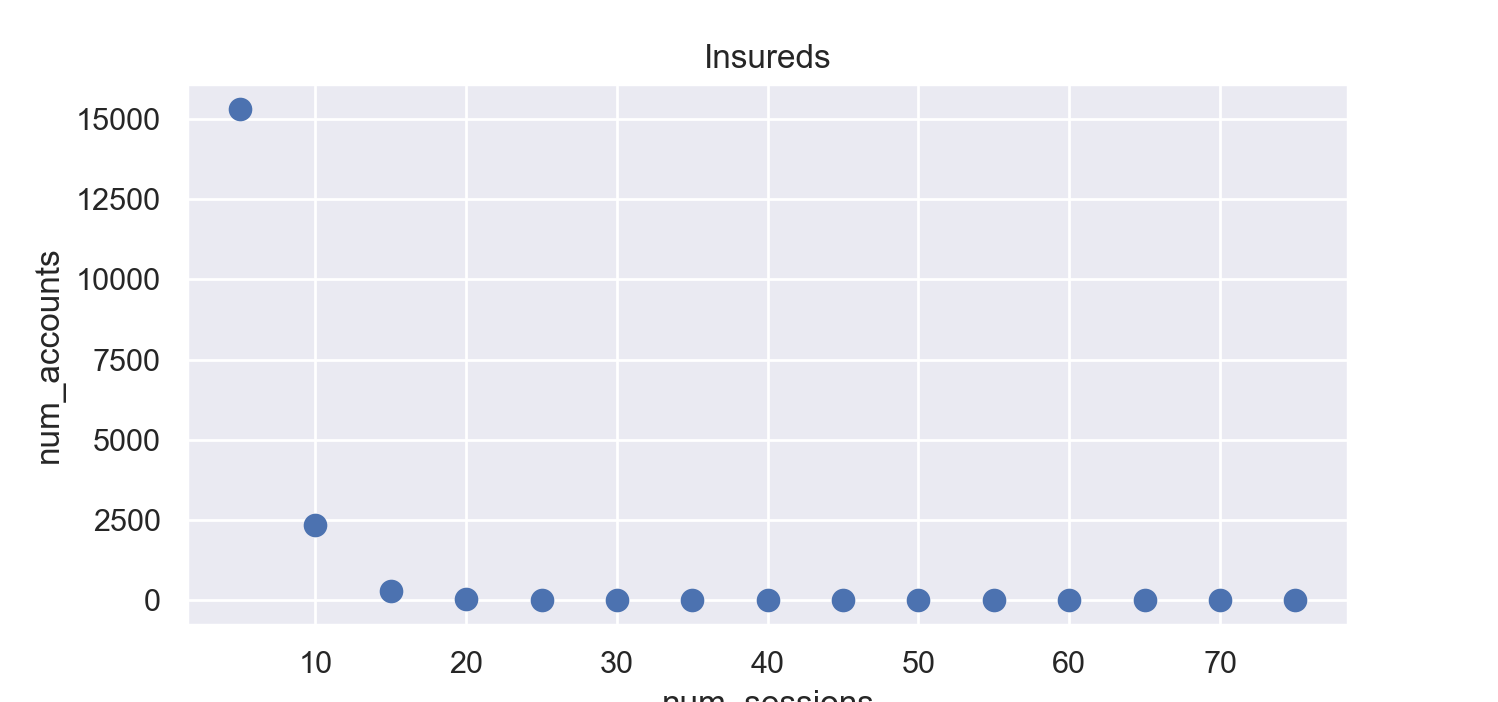

In [1050]:
ax = plot_hist(get_hist(insured_account_session_counts, 5),
          xlabel='num_sessions', ylabel='num_accounts',title='Insureds')
ax.grid('True')

In [199]:
ax = plot_hist(get_hist(insured_account_session_counts, 5),
          xlabel='num_sessions', ylabel='num_accounts',title='Insureds',cumulative=True, max_scale=True)
ax.grid('True')

<IPython.core.display.Javascript object>

Brokers

In [1051]:
broker_account_session_counts = df_inv_user_account[~df_inv_user_account.is_insured][[
    'account_number', 'num_sessions']].drop_duplicates().sort_values('num_sessions', ascending=False)['num_sessions']

In [1052]:
get_hist(broker_account_session_counts, 2)

[array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34,
        36, 38, 40, 42, 44, 46]),
 array([2297, 2290, 1009,  522,  211,  120,   55,   22,   14,    2,    4,
           1,    0,    1,    0,    0,    0,    0,    0,    0,    0,    0,
           1])]

<IPython.core.display.Javascript object>


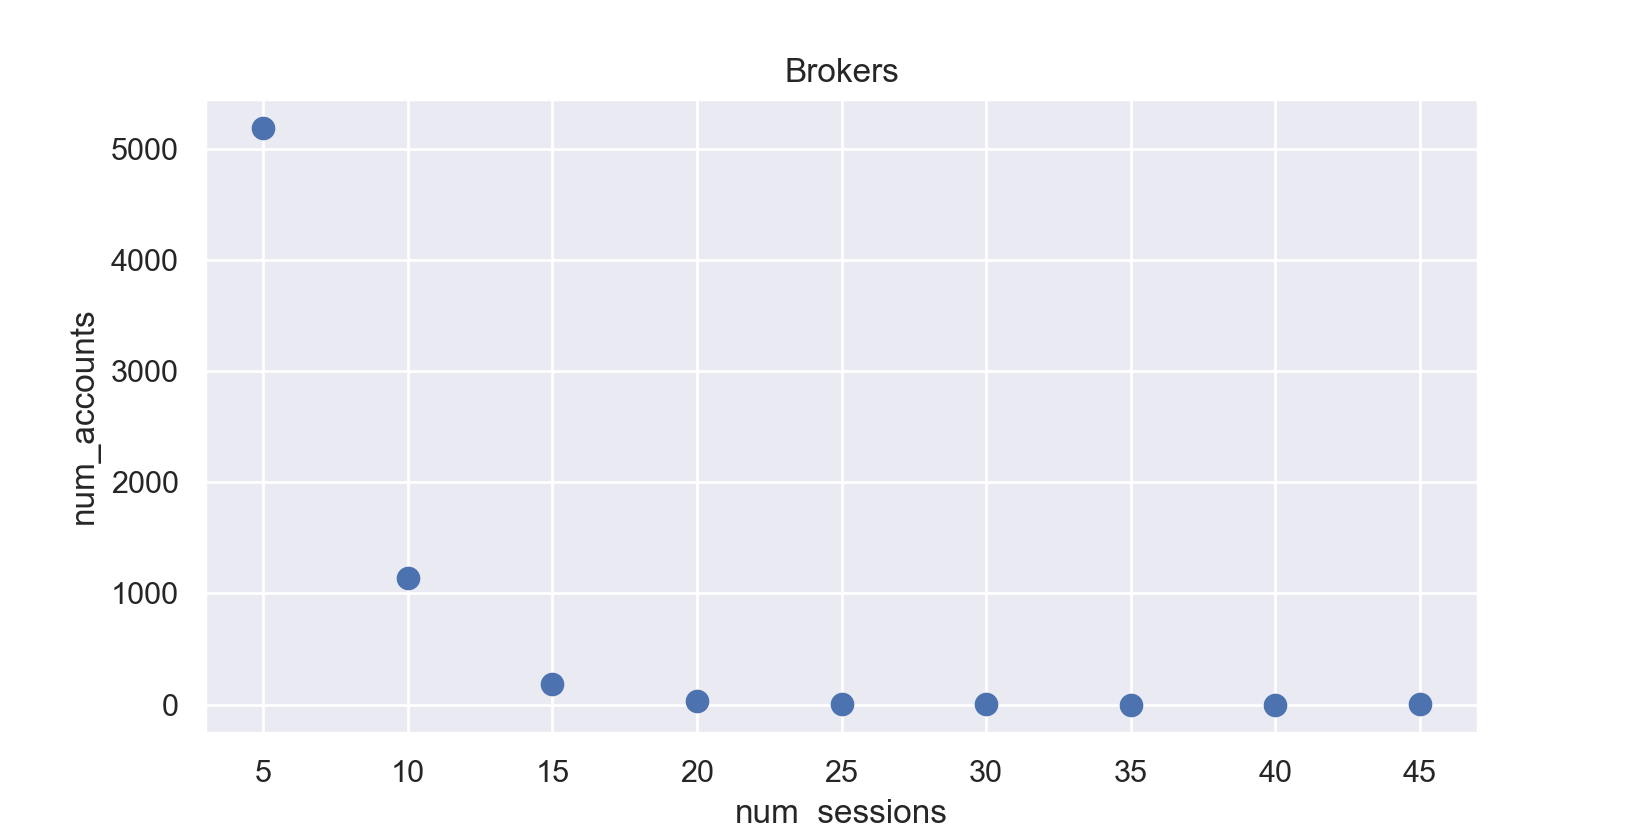

In [1053]:
ax = plot_hist(get_hist(broker_account_session_counts, 5),
          xlabel='num_sessions', ylabel='num_accounts',title='Brokers')
ax.grid('True')

<IPython.core.display.Javascript object>


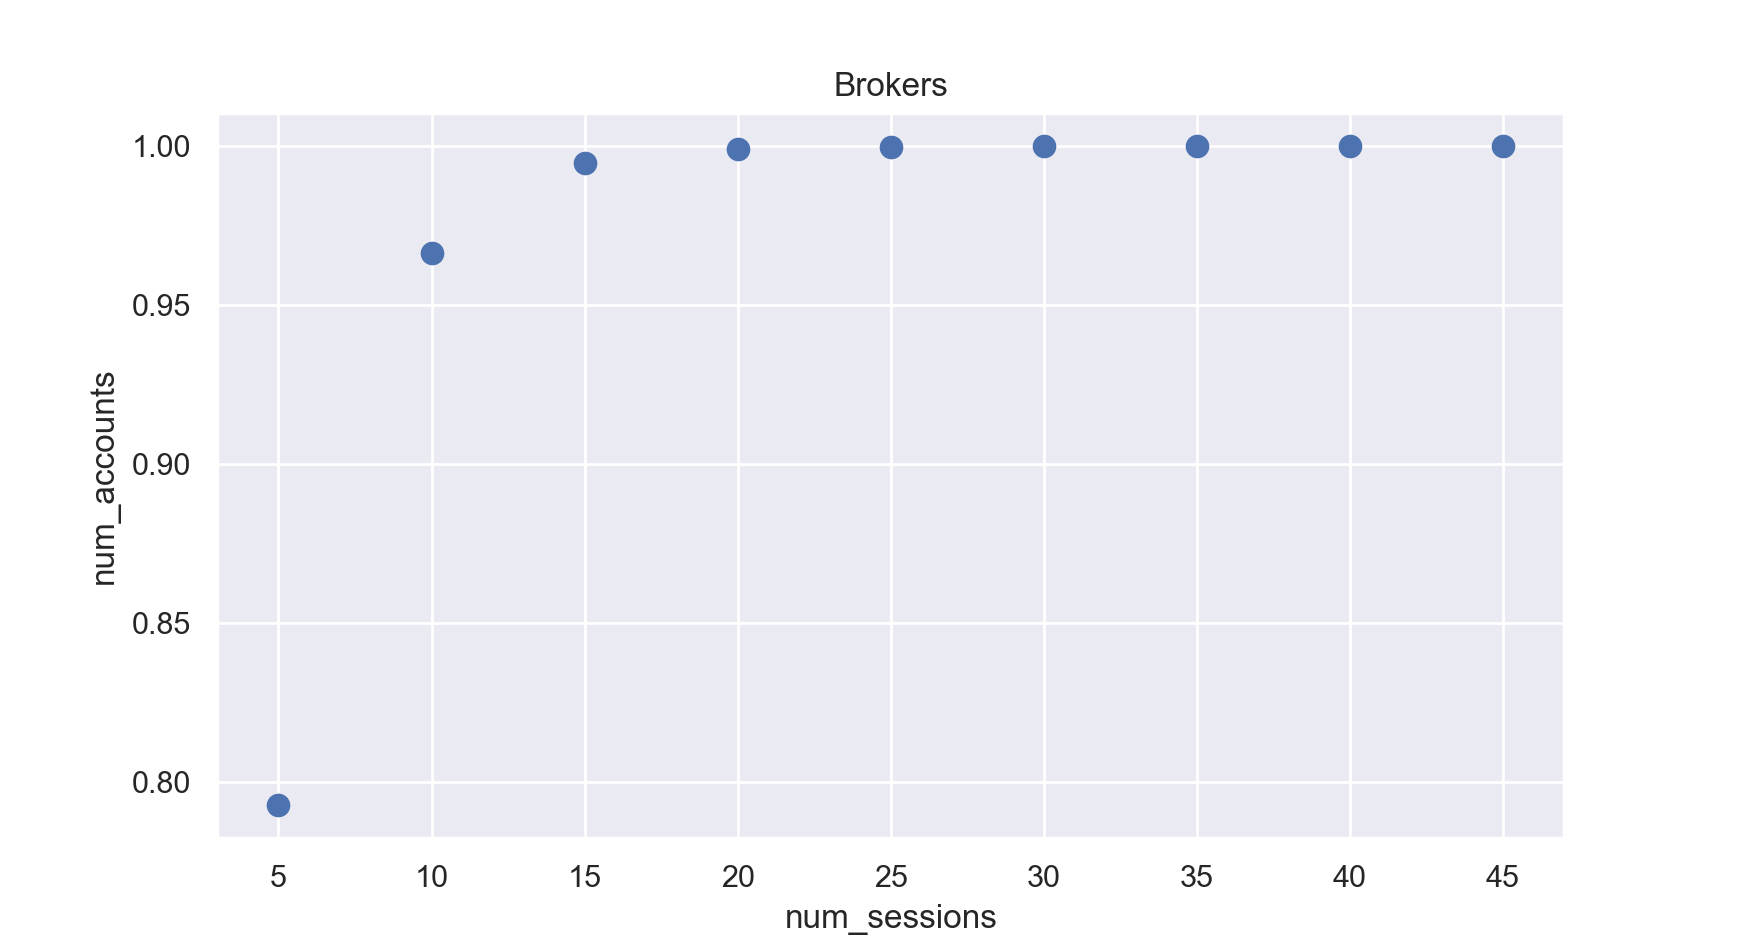

In [1054]:
ax = plot_hist(get_hist(broker_account_session_counts, 5),
          xlabel='num_sessions', ylabel='num_accounts',title='Brokers',cumulative=True, max_scale=True)
ax.grid('True')

Why are some accounts so high touch with the invoice page?  
Align in time with invoice emails sent, reminder emails if not on autopay

Policies table has multiple transaction rows per account number
- Use timestamps of most_recent_transaction_date to find closest event to invoice page visit

Ticket Link Clicks by User Type

In [1055]:
df_inv_user_account[df_inv_user_account.zd_event ==
                    'ticket'].groupby(['is_insured'])['account_number'].nunique()

is_insured
False    175
True     566
Name: account_number, dtype: int64

Ticket Link Clicks is mostly once per account

In [1056]:
df_inv_user_account[df_inv_user_account.zd_event ==
                    'ticket'].groupby(['account_number'])['session_id'].nunique()

account_number
7732193       1
21375955      1
49954336      1
88395453      2
92469784      1
             ..
9888053713    1
9966392561    1
9987061473    1
9988199021    1
9997712944    1
Name: session_id, Length: 729, dtype: int64

In [1057]:
df_inv_user_account[df_inv_user_account.zd_event ==
                    'ticket'].groupby(['account_number'])['session_id'].nunique().value_counts()

1    654
2     69
3      5
4      1
Name: session_id, dtype: int64

### Broker Segment

In [1058]:
#join 
df_inv_pol.head(2)

session_id                invoice_time  account_id  account_number  \
0  1574262222271  2019-11-20 15:03:45.857000       53022      6543079337   
1  1574262222271  2019-11-20 15:03:45.857000       53022      6543079337   

              account_name                    due_date  invoice_amount  \
0  Pelagic Outfitters Inc.  2019-10-26 00:00:00.000000          495.82   
1  Pelagic Outfitters Inc.  2019-10-26 00:00:00.000000          495.82   

              policy_number product_type policy_producer_code  \
0  GARATL00001HIBP-14262-02          BOP          GARATL00001   
1  GARATL00001HIBP-14262-01          BOP          GARATL00001   

  policy_broker_segments              effective_date             insured_name  \
0    Small Retail Direct  2020-04-26 00:01:00.000000  Pelagic Outfitters Inc.   
1    Small Retail Direct  2019-04-26 00:01:00.000000  Pelagic Outfitters Inc.   

  base_state  gross_written_premium most_recent_transaction  \
0   New York                5661.29                 renewal   
1   New York                5561.78           policy change   

  most_recent_transaction_date bop_predominant_industry  class_code   status  
0   2020-03-27 13:25:33.027000               Mercantile     59526.0   active  
1   2020-02-12 22:33:56.300000               Mercantile     59526.0  expired

In [948]:
df_inv_pol['policy_broker_segments'] = df_inv_pol.policy_broker_segments.str.strip('[""]')

In [956]:
df_inv_pol.groupby('policy_broker_segments')[
    'session_id'].nunique().sort_values(ascending=False).to_frame('nsessions').reset_index()

policy_broker_segments  nsessions
0                            Wholesale      25168
1                  Small Retail Direct      12882
2  Small Retail Agency Network (child)       7627
3     Small Retail Subproducer (child)       4395
4                         Large Retail        731
5                       Agency Network        684
6                              Digital        463
7                    Strategic Partner        169

In [980]:
df_matched_tickets.segment.value_counts().sum()

8335

In [991]:
df_matched_tickets.groupby('segment')['ticket_id'].nunique(
).to_frame('ntickets').reset_index().sort_values('ntickets',ascending=False)

segment  ntickets
7                            Wholesale      2609
4                  Small Retail Direct      1086
3  Small Retail Agency Network (child)       720
5     Small Retail Subproducer (child)       407
2                         Large Retail        78
1                              Digital        44
0                       Agency Network        40
6                    Strategic Partner        11

In [993]:
segment_comp = df_inv_pol.groupby('policy_broker_segments')['session_id'].nunique(
).sort_values(ascending=False).to_frame('nsessions').reset_index().merge(
    df_matched_tickets.groupby('segment')['ticket_id'].nunique(
).to_frame('ntickets').reset_index().sort_values('ntickets',ascending=False)
    ,left_on='policy_broker_segments', right_on='segment')

In [995]:
segment_comp.drop('segment',axis=1, inplace=True)

In [1001]:
segment_comp.rename(columns={'policy_broker_segments':'segment',
                            'invoice':'invoice_sessions_unique',
                            'ticket':'ticket_count_unique'}, inplace=True)

9-10% ticket submission rate for most segments

In [1003]:
segment_comp['ratio'] = segment_comp.ticket_count_unique/segment_comp.invoice_sessions_unique
segment_comp

segment  invoice_sessions_unique  \
0                            Wholesale                    25168   
1                  Small Retail Direct                    12882   
2  Small Retail Agency Network (child)                     7627   
3     Small Retail Subproducer (child)                     4395   
4                         Large Retail                      731   
5                       Agency Network                      684   
6                              Digital                      463   
7                    Strategic Partner                      169   

   ticket_count_unique     ratio  
0                 2609  0.103663  
1                 1086  0.084304  
2                  720  0.094401  
3                  407  0.092605  
4                   78  0.106703  
5                   40  0.058480  
6                   44  0.095032  
7                   11  0.065089

Only need to consider top 3 or 4 segments to get >=88% tickets

In [1389]:
segment_comp.ticket_count_unique.cumsum()/segment_comp.ticket_count_unique.sum()

0    0.522322
1    0.739740
2    0.883884
3    0.965365
4    0.980981
5    0.988989
6    0.997798
7    1.000000
Name: ticket_count_unique, dtype: float64

Segments of insured vs uninsured

In [1234]:
df_matched_tickets.groupby('is_broker')['ticket_id'].nunique()/5416

is_broker
False    0.47729
True     0.52271
Name: ticket_id, dtype: float64

In [1235]:
df_matched_tickets.groupby(['is_broker','segment'])['ticket_id'].nunique()

is_broker  segment                            
False      Agency Network                           25
           Digital                                  24
           Large Retail                             30
           Small Retail Agency Network (child)     240
           Small Retail Direct                     397
           Small Retail Subproducer (child)        162
           Strategic Partner                         6
           Wholesale                              1256
True       Agency Network                           15
           Digital                                  20
           Large Retail                             48
           Small Retail Agency Network (child)     480
           Small Retail Direct                     689
           Small Retail Subproducer (child)        245
           Strategic Partner                         5
           Wholesale                              1353
Name: ticket_id, dtype: int64

### Producer distribution

In [1376]:
from pandas.api.types import CategoricalDtype

In [1554]:
df_all_brokers.final_producer_code.nunique()

3620

In [ ]:
segment_comp = df_inv_pol.groupby('policy_broker_segments')['session_id'].nunique(
).sort_values(ascending=False).to_frame('nsessions').reset_index().merge(
    df_matched_tickets.groupby('segment')['ticket_id'].nunique(
).to_frame('ntickets').reset_index().sort_values('ntickets',ascending=False)
    ,left_on='policy_broker_segments', right_on='segment')

In [1377]:
ssp = df_inv_pol.groupby(['base_state', 'policy_broker_segments'])['policy_producer_code'].nunique(
).reset_index().astype({'base_state':CategoricalDtype(categories=state_order,ordered=True)})
# df_inv_pol.head()p 

In [1386]:
ssp.sort_values(['base_state','policy_broker_segments']).head(30)

base_state               policy_broker_segments  policy_producer_code
137    New York                       Agency Network                     2
138    New York                              Digital                     2
139    New York                         Large Retail                     4
140    New York  Small Retail Agency Network (child)                   109
141    New York                  Small Retail Direct                   200
142    New York     Small Retail Subproducer (child)                    58
143    New York                            Wholesale                    52
35      Florida                       Agency Network                     3
36      Florida                              Digital                     2
37      Florida                         Large Retail                    16
38      Florida  Small Retail Agency Network (child)                   159
39      Florida                  Small Retail Direct                   150
40      Florida     Small Retail Subproducer (child)                   168
41      Florida                    Strategic Partner                     1
42      Florida                            Wholesale                    71
188       Texas                       Agency Network                     6
189       Texas                              Digital                     2
190       Texas                         Large Retail                     9
191       Texas  Small Retail Agency Network (child)                   141
192       Texas                  Small Retail Direct                   107
193       Texas     Small Retail Subproducer (child)                    24
194       Texas                    Strategic Partner                     1
195       Texas                            Wholesale                    41
126  New Jersey                       Agency Network                     1
127  New Jersey                              Digital                     2
128  New Jersey                         Large Retail                     4
129  New Jersey  Small Retail Agency Network (child)                    61
130  New Jersey                  Small Retail Direct                   115
131  New Jersey     Small Retail Subproducer (child)                    23
132  New Jersey                            Wholesale                    39

75% of tickets created by top 250 producers

In [1468]:
(df_inv_pol.policy_producer_code.value_counts().sort_values(ascending=False).cumsum(
)/df_inv_pol.policy_producer_code.value_counts().sort_values(ascending=False).sum())[:250]

MORSTAN00001      0.069464
APPUND0001        0.124844
JOHN00001         0.165910
BTIS00001         0.197745
CMFRST00001       0.228889
                    ...   
FOROFF00001       0.748618
TMKKALL00001      0.749319
NYSMAORISUR1      0.750021
SIASANCDT00001    0.750711
ARIUNW00001       0.751388
Name: policy_producer_code, Length: 250, dtype: float64

In [1428]:
ip = df_inv_pol.policy_producer_code.value_counts().sort_values(ascending=False).reset_index()

In [1429]:
tp = df_matched_tickets.producer_code.value_counts().reset_index()

Around 5-10% ticket submission rate for top producers

In [1453]:
# pltdf = ip.merge(tp, how='left', on='index').reset_index().drop(
#     'index', axis=1).rename(columns={'policy_producer_code':'invoice','producer_code':'tickets'}).\
# melt(id_vars='level_0')
pltdf = ip.merge(tp, how='left', on='index').reset_index().drop('index', axis=1).rename(
    columns={'policy_producer_code': 'invoice', 'producer_code': 'tickets'}).fillna(0)
pltdf['ratio'] = pltdf.tickets/pltdf.invoice
pltdf

level_0  invoice  tickets     ratio
0           0     5741    343.0  0.059746
1           1     4577    292.0  0.063797
2           2     3394    285.0  0.083972
3           3     2631    201.0  0.076397
4           4     2574     83.0  0.032246
...       ...      ...      ...       ...
1868     1868        1      0.0  0.000000
1869     1869        1      0.0  0.000000
1870     1870        1      0.0  0.000000
1871     1871        1      0.0  0.000000
1872     1872        1      0.0  0.000000

[1873 rows x 4 columns]

In [1469]:
# Moving average (doesn't really make sense since not a timeseries)
# pltdf.ratio.rolling(3).mean().fillna(0).reset_index().head()

<IPython.core.display.Javascript object>


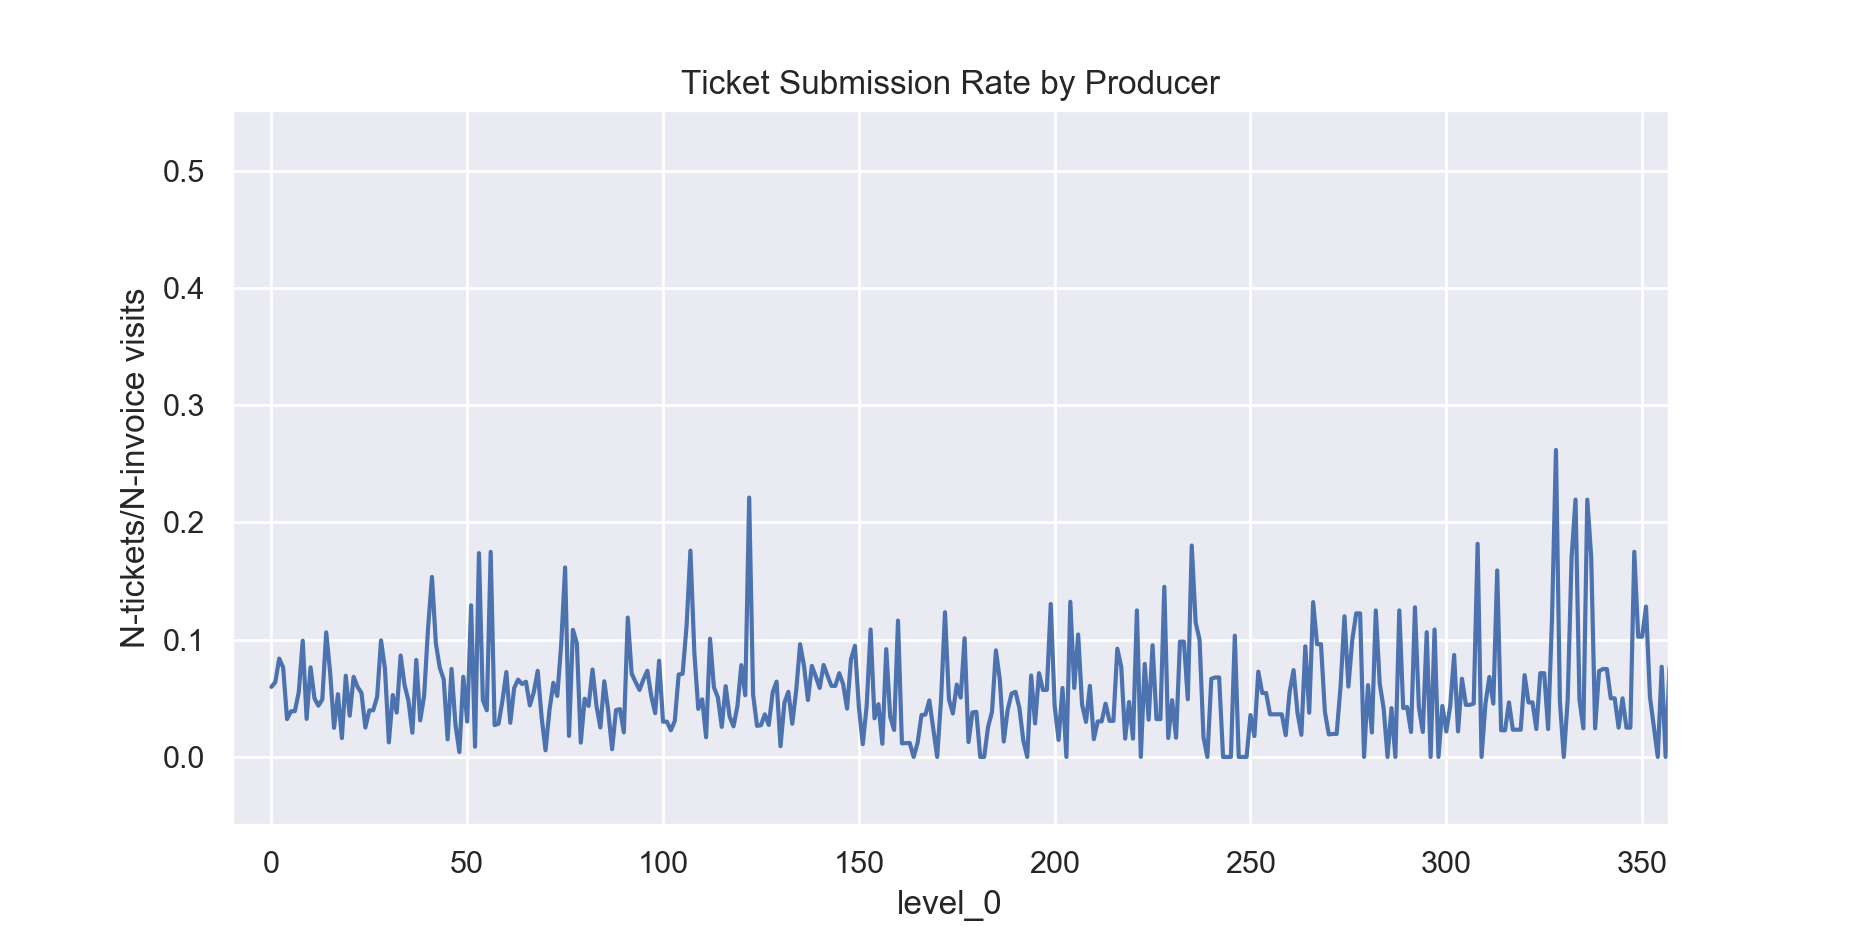

Text(0.5, 1.0, 'Ticket Submission Rate by Producer')

Text(0, 0.5, 'N-tickets/N-invoice visits')

In [1476]:
ax = sns.lineplot(
#     data = pltdf.ratio.rolling(5).mean().fillna(0).reset_index(),
    data = pltdf,
            x='level_0',y='ratio'
#              ,hue='variable'
            )

ax.set_title('Ticket Submission Rate by Producer')
ax.set_ylabel('N-tickets/N-invoice visits')

### Sample Size

Get conversion rate bounds, compute sample sizes

In [1517]:
data.groupby('date')['session_id'].sum().head()

date
2019-46     861
2019-47    1121
2019-48    1705
2019-49    1549
2019-50    1570
Name: session_id, dtype: int64

<IPython.core.display.Javascript object>


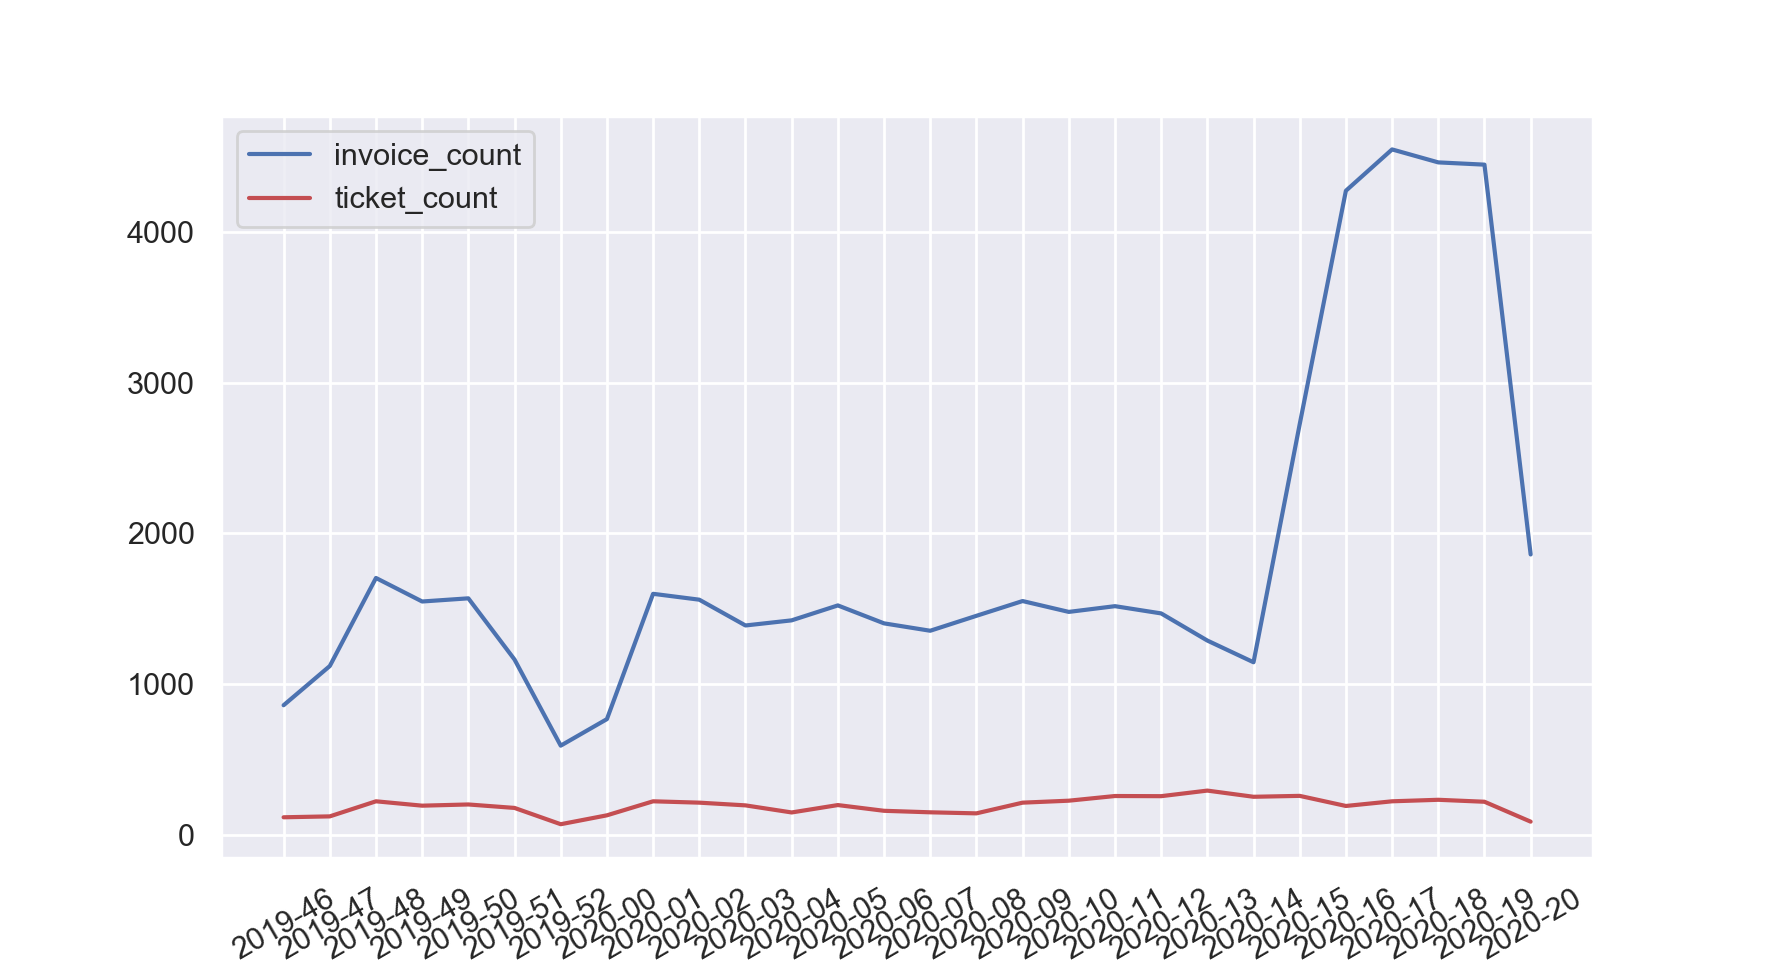

In [1539]:
fig, ax = plt.subplots()

i_data = data.groupby('date')['session_id'].sum().reset_index()
t_data = df_matched_tickets.groupby('date')['ticket_id'].nunique().reset_index()

ax.plot(i_data.date.values, i_data.session_id.values,'-b',label='invoice_count')
ax.plot(t_data.date.values, t_data.ticket_id.values,'-r',label='ticket_count')
plt.xticks(rotation=30);
ax.legend();

In [1537]:
merged[:20].session_id.mean()
merged[:20].ratio.mean()

1353.15

0.13499798635239155

<IPython.core.display.Javascript object>


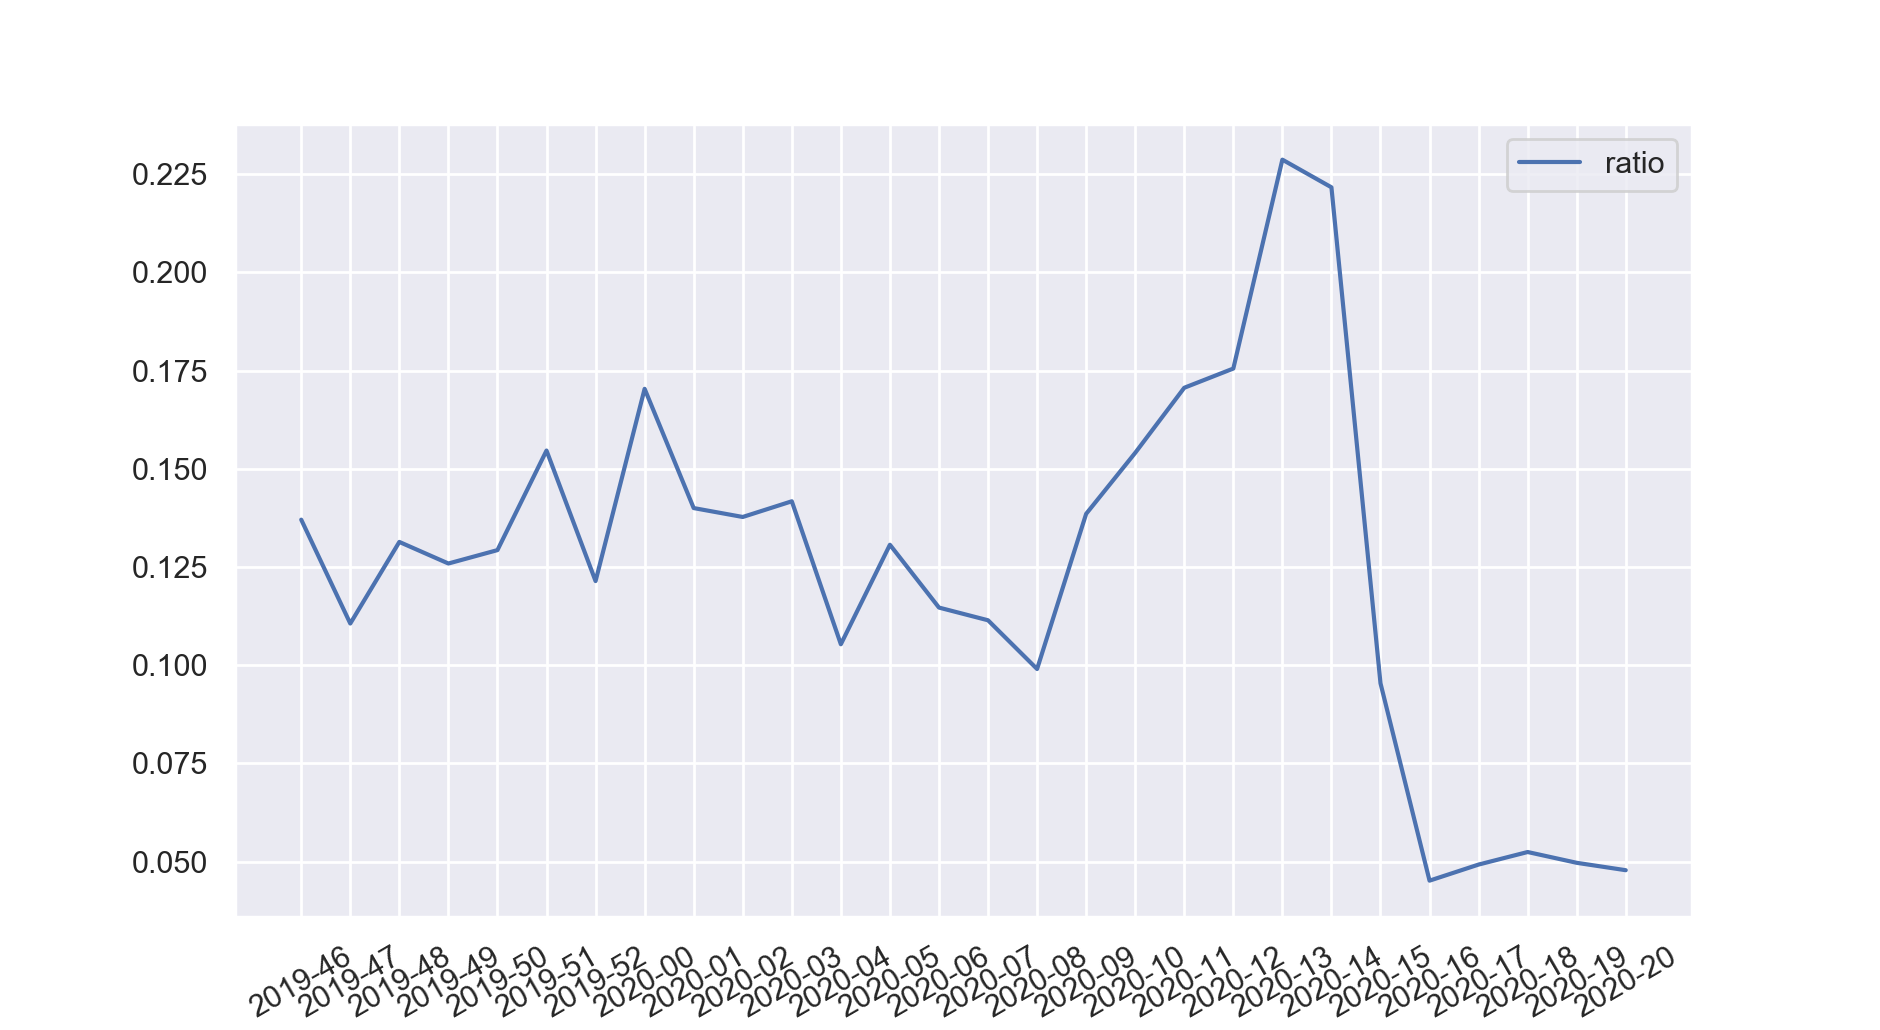

In [1532]:
fig, ax = plt.subplots()

i_data = data.groupby('date')['session_id'].sum().reset_index()
t_data = df_matched_tickets.groupby('date')['ticket_id'].nunique().reset_index()
merged = t_data.merge(i_data)
merged['ratio'] = merged.ticket_id/merged.session_id

ax.plot(merged.date.values, merged.ratio.values,'-b',label='ratio')
plt.xticks(rotation=30);
ax.legend();

Test Set up

In [6]:
print(f"Num unique producers that visited invoice page: {df_inv_pol.policy_producer_code.nunique()}")

NameError: name 'df_inv_pol' is not defined

Populate control and treament producer code groups

In [7]:
test_fraction = 0.43
test_codes = pd.Series(df_inv_pol.policy_producer_code.unique()).sample(frac=test_fraction, random_state=42)
treatment_codes = test_codes.sample(frac=.50, random_state=42).values
control_codes = test_codes[~test_codes.isin(treatment_codes)]

NameError: name 'df_inv_pol' is not defined

In [1604]:
print(f"Test fraction: {test_fraction}")
print(f"Num unique producers that visited invoice page: {df_inv_pol.policy_producer_code.nunique()}")
print(f"Test Size: {test_codes.size}")
print(f"Control Size: {control_codes.size}")
print(f"Treatment Size: {treatment_codes.size}")

Test fraction: 0.43
Num unique producers that visited invoice page: 1873
Test Size: 806
Control Size: 403
Treatment Size: 403


In [1588]:
state = df_inv_pol[['session_id', 'invoice_time', 'base_state', 'policy_producer_code']].astype(
    {'invoice_time': np.datetime64}).merge(df_inv_user_account[['session_id', 'is_insured', 'zd_event']]).drop_duplicates()

In [1591]:
state['control'] = state.policy_producer_code.isin(control_codes)
state['treatment'] = state.policy_producer_code.isin(treatment_codes)

In [1597]:
state[((state.control)|(state.treatment))].count()

session_id              20043
invoice_time            20043
base_state              20041
policy_producer_code    20041
is_insured              20043
zd_event                  369
control                 20043
treatment               20043
dtype: int64

In [1599]:
state['date'] = state.invoice_time.dt.strftime('%Y-%W')

In [1600]:
state.head()

session_id            invoice_time base_state policy_producer_code  \
0   1574262222271 2019-11-20 15:03:45.857   New York          GARATL00001   
2   1574263159665 2019-11-20 15:20:28.067   New York          GLOBAL00001   
3   1574263483733 2019-11-20 15:27:00.045    Alabama         SIAALSH00001   
4   1574263483733 2019-11-20 15:27:00.045    Florida         SIAALSH00001   
10  1574265676629 2019-11-20 16:01:54.450   New York         MORSTAN00001   

    is_insured zd_event  control  treatment     date  
0         True     None    False      False  2019-46  
2        False     None    False      False  2019-46  
3         True     None    False      False  2019-46  
4         True     None    False      False  2019-46  
10        True     None    False      False  2019-46

In [1711]:
invoice_counts = state[((state.control) | (state.treatment))].groupby(
    ['date', 'treatment'])['session_id'].nunique().reset_index()

In [1610]:
df_matched_tickets['control'] = df_matched_tickets.producer_code.isin(control_codes)
df_matched_tickets['treatment'] = df_matched_tickets.producer_code.isin(treatment_codes)

In [1713]:
ticket_counts = df_matched_tickets[((df_matched_tickets.control) | (df_matched_tickets.treatment))].groupby(
    ['date', 'treatment'])['ticket_id'].nunique().reset_index()

In [1714]:
ticket_counts.head()

date  treatment  ticket_id
0  2019-46      False         31
1  2019-46       True         23
2  2019-47      False         28
3  2019-47       True         40
4  2019-48      False         47

Conversion Rate Difference

In [1630]:
#ratio
# ticket_counts.drop('control', axis=1).head(2)
# invoice_counts.drop('control', axis=1).head(2)
merged = invoice_counts.drop('control', axis=1).merge(ticket_counts.drop('control', axis=1),
                                            on=['date','treatment'], how='left')

In [1668]:
# merged.groupby('treatment').transform(lambda x: x.expanding().sum())
cume = merged.groupby('treatment')[['ticket_id', 'session_id']].cumsum().rename(
    columns={'ticket_id': 'tcume', 'session_id':'icume'})

In [1671]:
merged = merged.join(cume)

In [1691]:
merged.head()

date  treatment  session_id  ticket_id     ratio  tcume  icume
0  2019-46       True         157         23  0.146497     23    157
1  2019-46      False         154         31  0.201299     31    154
2  2019-47       True         189         40  0.211640     63    346
3  2019-47      False         225         28  0.124444     59    379
4  2019-48       True         297         57  0.191919    120    643

In [1692]:
cc = merged[merged.treatment].apply(lambda x: x['tcume']/x['icume'], axis=1).values - \
merged[~merged.treatment].apply(lambda x: x['tcume']/x['icume'], axis=1).values

In [1693]:
conversion_expanding = pd.DataFrame({'date':merged['date'].unique(), 'conversion':cc})

<IPython.core.display.Javascript object>


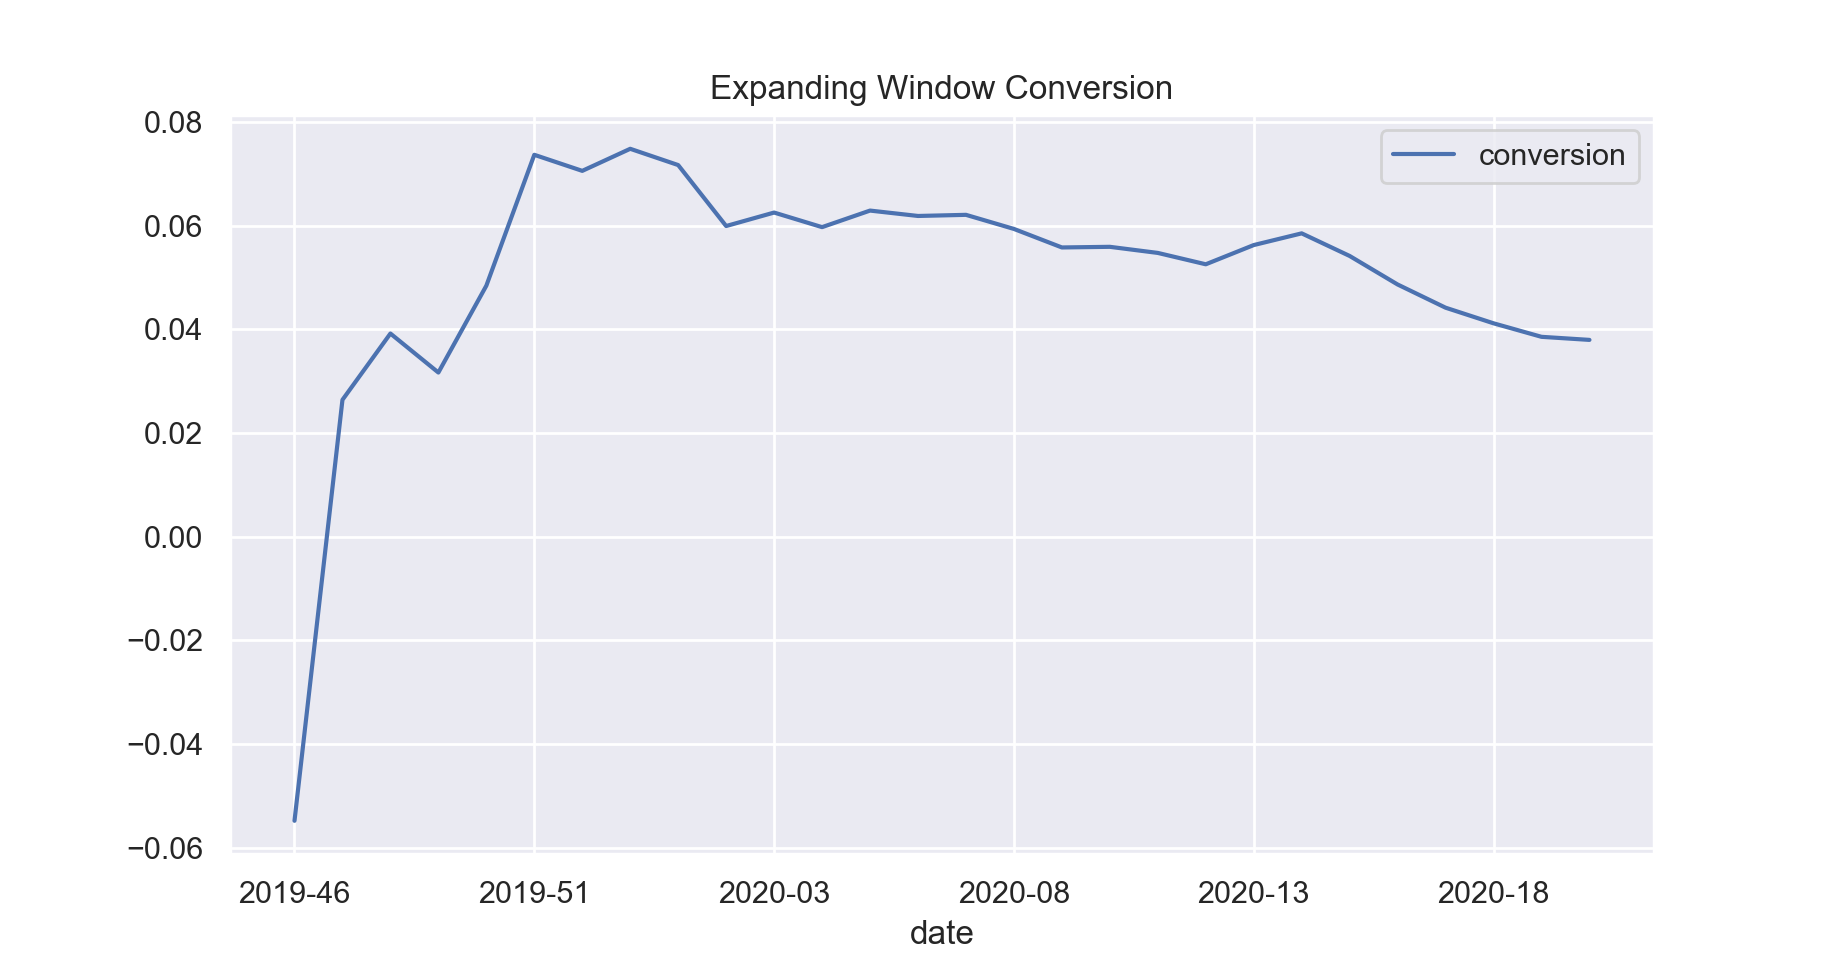

In [1700]:
conversion_expanding.plot(x='date',y='conversion', title='Expanding Window Conversion')

In [1709]:
conversion_expanding[conversion_expanding.date=='2020-13']

date  conversion
20  2020-13    0.056265

In [1635]:
fig, ax = plt.subplots()

ax.plot(merged[merged.treatment].date.values, merged[merged.treatment].ratio.values,'-r',label='treatment')
ax.plot(merged[~merged.treatment].date.values, merged[~merged.treatment].ratio.values,'-b',label='control')
plt.xticks(rotation=30);
ax.legend();

<IPython.core.display.Javascript object>

In [1710]:
for i in range(2):
    test_fraction = 0.43
    test_codes = pd.Series(df_inv_pol.policy_producer_code.unique()).sample(frac=test_fraction, random_state=42)
    treatment_codes = test_codes.sample(frac=.50, random_state=42).values
    control_codes = test_codes[~test_codes.isin(treatment_codes)]
    
    state['treatment'] = state.policy_producer_code.isin(treatment_codes)
    state['control'] = state.policy_producer_code.isin(control_codes)
    df_matched_tickets['treatment'] = df_matched_tickets.producer_code.isin(treatment_codes)
    df_matched_tickets['treatment'] = df_matched_tickets.producer_code.isin(treatment_codes)
    
    invoice_counts = state[((state.control) | (state.treatment))].groupby(
    ['date', 'treatment'])['session_id'].nunique().reset_index()
    ticket_counts = df_matched_tickets[((df_matched_tickets.control) | (df_matched_tickets.treatment))].groupby(
    ['date', 'treatment'])['ticket_id'].nunique().reset_index()
    
    merged = invoice_counts.merge(ticket_counts, on=['date','treatment'], how='left')
    
    cume = merged.groupby('treatment')[['ticket_id', 'session_id']].cumsum().rename(
    columns={'ticket_id': 'tcume', 'session_id':'icume'})
    
    merged = merged.join(cume)
    cc = merged[merged.treatment].apply(lambda x: x['tcume']/x['icume'], axis=1).values - \
    merged[~merged.treatment].apply(lambda x: x['tcume']/x['icume'], axis=1).values

Stratified Sample

In [1489]:
df_inv_pol.groupby(['base_state', 'policy_broker_segments'])[
    'policy_producer_code'].agg(lambda x: x.sample(frac=.2).tolist()).reset_index()

base_state               policy_broker_segments  \
0          Alabama                              Digital   
1          Alabama                         Large Retail   
2          Alabama  Small Retail Agency Network (child)   
3          Alabama                  Small Retail Direct   
4          Alabama     Small Retail Subproducer (child)   
..             ...                                  ...   
209  West Virginia                            Wholesale   
210      Wisconsin  Small Retail Agency Network (child)   
211      Wisconsin                  Small Retail Direct   
212      Wisconsin                            Wholesale   
213        Wyoming                            Wholesale   

                                  policy_producer_code  
0                                                   []  
1    [HUBGULSOU00001, HUBGULSOU00001, HUBGULSOU0000...  
2    [IRQDLHUM00001, SIAALDR00001, SIAALCA00001, SI...  
3    [THOMASHA00001, MARINE00001, MARINE00001, THAM...  
4    [LONBURKHOLD00001, DARLING00001, DARLING00001,...  
..                                                 ...  
209                                                 []  
210                                  [NJSMASEJONGINS1]  
211  [STEINFIELD00001, TAOGLOCHI00001, TAOGLOCHI000...  
212                             [BTIS00001, BTIS00001]  
213                                        [BTIS00001]  

[214 rows x 3 columns]

### Time & State

In [1006]:
df_matched_tickets.head(2)

ticket_id                  created_at          account_number via_channel  \
0     179961  2019-11-22 18:02:51.000000              9645539554       voice   
1     179992  2019-11-22 18:38:42.000000  JOHN00001HIBP-08177-01       voice   

                                                tags email domain    segment  \
0  ["billing_inquiries", "inbound_call", "payment...  None   None  Wholesale   
1  ["billing_inquiries", "document_requested", "i...  None   None       None   

  clean_account_number  is_broker  found_pc  
0           9645539554      False      True  
1                 None      False     False

In [1306]:
df_matched_tickets['created_at'] = df_matched_tickets.created_at.map(lambda x: pd.to_datetime(x))

In [1506]:
# df_matched_tickets['month'] = df_matched_tickets.created_at.dt.strftime('%Y-%m')
df_matched_tickets['date'] = df_matched_tickets.created_at.dt.strftime('%Y-%W')

In [1507]:
df_matched_tickets.groupby('date')['ticket_id'].nunique().reset_index().head()

date  ticket_id
0  2019-46        118
1  2019-47        124
2  2019-48        224
3  2019-49        195
4  2019-50        203

In [1126]:
session_policy_slim = df_inv_pol[['session_id', 'account_number', 'base_state', 'gross_written_premium',
            'bop_predominant_industry', 'class_code']].drop_duplicates(
    subset=['session_id', 'account_number']).replace({np.nan:None}).astype({'account_number':str}).copy()

In [1132]:
ticket_policy = df_matched_tickets.merge(
    session_policy_slim,
    how='left', right_on='account_number', 
    left_on='clean_account_number').drop_duplicates(subset=['ticket_id','account_number_y']).copy()

In [1146]:
ticket_policy.base_state.value_counts().sort_values(ascending=False).head()

New York          1165
Florida            853
Texas              456
New Jersey         194
South Carolina     189
Name: base_state, dtype: int64

Sessions by State

In [1059]:
state = df_inv_pol[['session_id', 'invoice_time', 'base_state']].astype({'invoice_time': np.datetime64}).merge(
    df_inv_user_account[['session_id', 'is_insured','zd_event']]).drop_duplicates()

In [1148]:
state.head()

session_id            invoice_time base_state  is_insured zd_event  \
0   1574262222271 2019-11-20 15:03:45.857   New York        True     None   
2   1574263159665 2019-11-20 15:20:28.067   New York       False     None   
3   1574263483733 2019-11-20 15:27:00.045    Alabama        True     None   
4   1574263483733 2019-11-20 15:27:00.045    Florida        True     None   
10  1574265676629 2019-11-20 16:01:54.450   New York        True     None   

      month     date  
0   2019-11  2019-46  
2   2019-11  2019-46  
3   2019-11  2019-46  
4   2019-11  2019-46  
10  2019-11  2019-46

In [1061]:
state['month'] = state.invoice_time.dt.strftime('%Y-%m')
state['date'] = state.invoice_time.dt.strftime('%Y-%W')

In [1062]:
# get ticket counts
tickets_time = state[state.zd_event == 'ticket'].groupby(['date', 'is_insured'])[
    'session_id'].nunique().reset_index()

In [1512]:
data = state.groupby(['date','is_insured'])['session_id'].nunique().reset_index()

In [1513]:
data.head()

date  is_insured  session_id
0  2019-46       False         166
1  2019-46        True         695
2  2019-47       False         180
3  2019-47        True         941
4  2019-48       False         339

In [1509]:
df_matched_tickets.groupby('date')['ticket_id'].nunique().reset_index()

date  ticket_id
0   2019-46        118
1   2019-47        124
2   2019-48        224
3   2019-49        195
4   2019-50        203
5   2019-51        180
6   2019-52         72
7   2020-00        131
8   2020-01        224
9   2020-02        215
10  2020-03        197
11  2020-04        150
12  2020-05        199
13  2020-06        161
14  2020-07        151
15  2020-08        144
16  2020-09        215
17  2020-10        228
18  2020-11        259
19  2020-12        258
20  2020-13        295
21  2020-14        254
22  2020-15        260
23  2020-16        193
24  2020-17        224
25  2020-18        234
26  2020-19        221
27  2020-20         89

In [ ]:
ax.xaxis.set_label()

Ticket rate looks pretty flat

In [1076]:
fig, ax = plt.subplots()

sns.lineplot(x='date',y='session_id',
             hue='is_insured',data=data, ax=ax)

t_data = df_matched_tickets.groupby('date')['ticket_id'].nunique().reset_index()
ax.plot(t_data.date.values, t_data.ticket_id.values,'-r',label='ticket_count')
plt.xticks(rotation=30);
ax.legend();

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


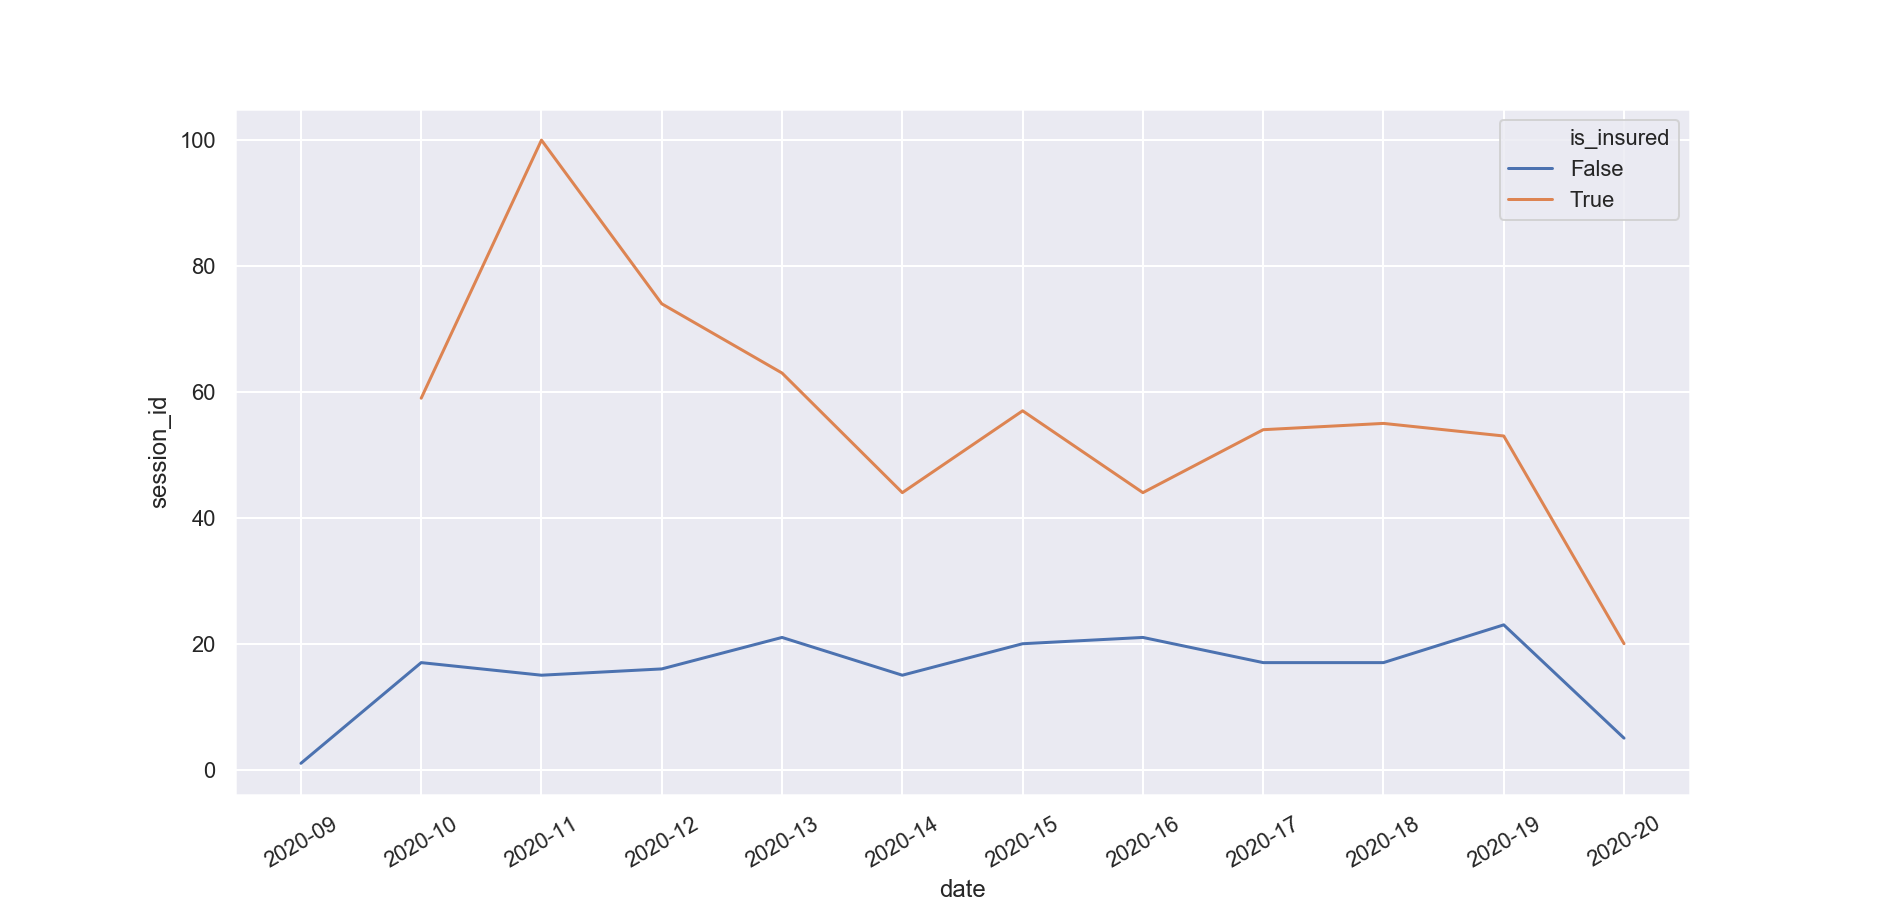

In [446]:
fig, ax = plt.subplots()

sns.lineplot(x='date',y='session_id',
             hue='is_insured',data=tickets_time, ax=ax)
plt.xticks(rotation=30);

During Covid we lowered the number of emails sent in moratorium states  
Dig into events in amplitude for covid insureds

In [353]:
state_date = state.groupby(['base_state','is_insured','date'])['session_id'].nunique().reset_index()

In [1149]:
data = state.groupby(['base_state', 'is_insured'])[
    'session_id'].nunique().reset_index()

In [1150]:
state_order = state.groupby(['base_state'])['session_id'].nunique(
).reset_index().sort_values('session_id',ascending=False)['base_state'].values.tolist()

In [1207]:
state_order[:10]

['New York',
 'Florida',
 'Texas',
 'New Jersey',
 'South Carolina',
 'California',
 'Alabama',
 'Louisiana',
 'Georgia',
 'North Carolina']

Sessions by State & User Type

In [1215]:
tc_plot = ticket_policy.base_state.value_counts().sort_values(ascending=False)\
.reset_index().rename({'base_state':'value','index':'base_state'}, axis=1)

In [1216]:
tc_plot['cat'] = 'ticket_count'

In [1227]:
tc_plot[:20]

base_state  value           cat
0         New York   1165  ticket_count
1          Florida    853  ticket_count
2            Texas    456  ticket_count
3       New Jersey    194  ticket_count
4   South Carolina    189  ticket_count
5       California    172  ticket_count
6          Alabama     87  ticket_count
7          Georgia     71  ticket_count
8   North Carolina     65  ticket_count
9        Louisiana     65  ticket_count
10    Pennsylvania     39  ticket_count
11     Mississippi     32  ticket_count
12        Colorado     32  ticket_count
13        Oklahoma     20  ticket_count
14         Arizona     19  ticket_count
15        Missouri     17  ticket_count
16        Illinois     16  ticket_count
17        Michigan     13  ticket_count
18    Rhode Island     13  ticket_count
19           Maine     12  ticket_count

In [1219]:
pltdata = data.append(tc_plot)

In [1225]:
sns.barplot(y='base_state', x='value', hue='cat',
            data=pltdata[pltdata.base_state.isin(state_order[:20])],
            orient='h',order=state_order[:20])

<IPython.core.display.Javascript object>

State over time

Sessions by State, User Type before Covid

In [365]:
data = state_date[state_date.date < '2020-14'].groupby(
    ['base_state', 'is_insured'])['session_id'].sum().reset_index()
data.head()

base_state  is_insured  session_id
0    Alabama       False         125
1    Alabama        True         541
2    Arizona       False          14
3    Arizona        True          80
4   Arkansas       False           4

<IPython.core.display.Javascript object>


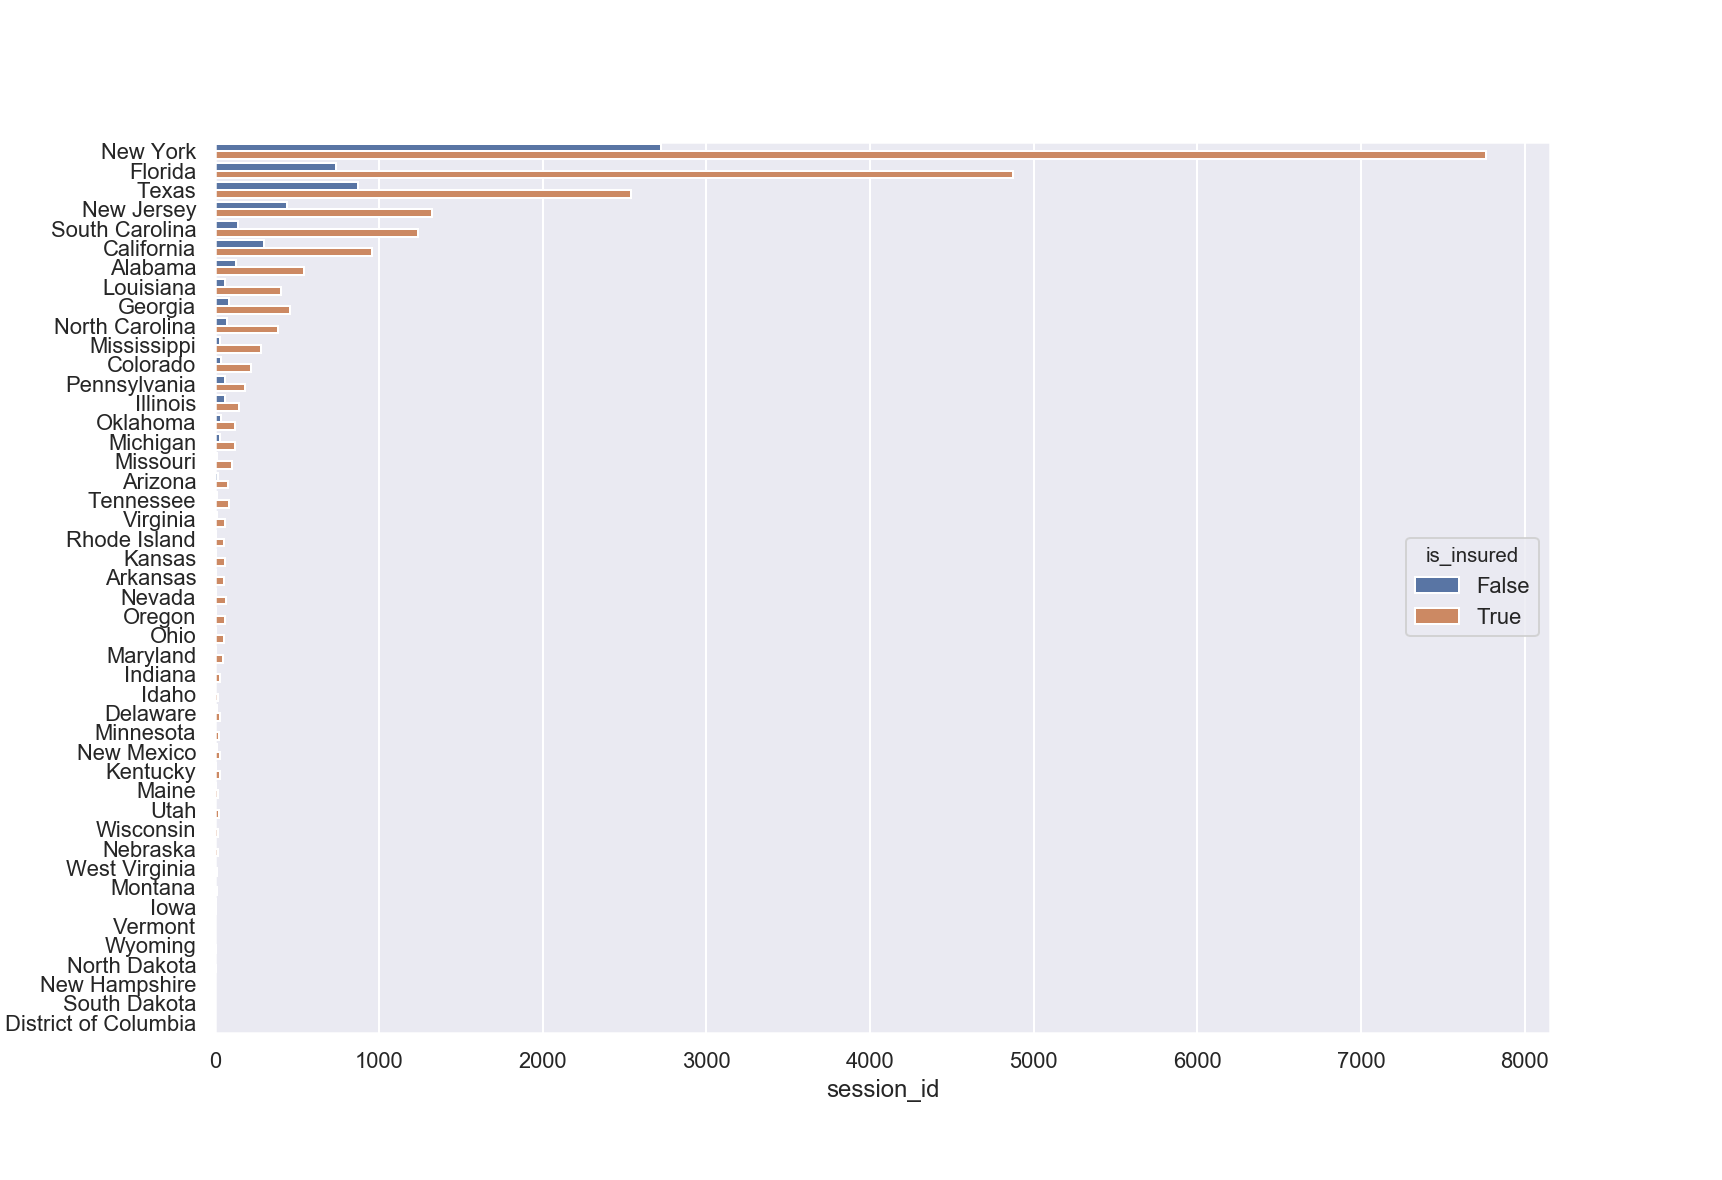

In [366]:
sns.barplot(y='base_state', x='session_id', hue='is_insured',
            data=data, orient='h',order=state_order)

Combine above plots and add tickets  
producer code and account tend to align geographically

### Broker Attributes

In [1279]:
df_inv_ba.isnull().mean().sort_values(ascending=True)[30:50]

sum_neilson_revenue                   0.812051
neilson_has_nationwide_appt           0.812051
bop_prem_first_30d                    0.812051
neilson_has_big_4_appt                0.812051
name                                  0.812051
os_name_favored                       0.812070
num_users_in_ui_events                0.812070
num_ui_events                         0.812070
num_late_nights                       0.812070
num_cities_in_ui_events               0.812070
num_accounts_declined_ui_events       0.812070
last_ui_event_at                      0.812070
first_ui_event_at                     0.812070
device_type_favored                   0.812070
num_agents                            0.812398
num_agent_roles                       0.812398
num_ui_class_selections_ineligible    0.813053
num_ui_class_selections               0.813053
num_accounts_created                  0.813130
num_portal_quotes                     0.814054
dtype: float64

In [1287]:
df_matched_tickets.groupby('producer_code')['ticket_id'].nunique().sort_values(ascending=False)

producer_code
MORSTAN00001    343
APPUND0001      292
JOHN00001       285
BTIS00001       201
APPUND0002      106
               ... 
LASMAUDB1         1
LEWLEW00001       1
LOGUDW00001       1
LONCRO00001       1
KINSLLC00001      1
Name: ticket_id, Length: 930, dtype: int64

how many producers per segment? producers per state?

### Covid

In [1300]:
df_matched_tickets[df_matched_tickets.tags.map(lambda x: 'covid' in x)].segment.value_counts()

Wholesale                              58
Small Retail Direct                    27
Small Retail Agency Network (child)    16
Small Retail Subproducer (child)       13
Large Retail                            2
Digital                                 2
Agency Network                          1
Name: segment, dtype: int64

In [1313]:
df_matched_tickets['covid'] = df_matched_tickets.tags.map(lambda x: 'covid' in x)

In [1326]:
df_matched_tickets[df_matched_tickets.covid].groupby([df_matched_tickets[df_matched_tickets.covid].created_at.dt.date, 'covid'])[
    'ticket_id'].nunique()

created_at  covid
2020-03-10  True      1
2020-03-17  True      2
2020-03-20  True      1
2020-03-23  True      2
2020-03-24  True      2
2020-03-25  True      3
2020-03-26  True      2
2020-03-27  True      2
2020-03-30  True      1
2020-03-31  True      9
2020-04-01  True      6
2020-04-02  True      4
2020-04-03  True      6
2020-04-06  True      5
2020-04-07  True      3
2020-04-08  True      9
2020-04-09  True      6
2020-04-10  True      6
2020-04-13  True      9
2020-04-14  True      5
2020-04-15  True      3
2020-04-16  True     10
2020-04-17  True      2
2020-04-20  True      1
2020-04-21  True      1
2020-04-22  True      4
2020-04-23  True      2
2020-04-27  True      3
2020-04-28  True      1
2020-04-29  True      1
2020-04-30  True      2
2020-05-01  True      2
2020-05-03  True      1
2020-05-04  True      1
2020-05-05  True      1
2020-05-08  True      1
2020-05-11  True      2
2020-05-12  True      3
2020-05-13  True      1
Name: ticket_id, dtype: int64

In [1344]:
df_matched_tickets.groupby([df_matched_tickets.created_at.dt.date])[
    'ticket_id'].nunique()[-55:]

created_at
2020-03-20    57
2020-03-21     2
2020-03-22     2
2020-03-23    55
2020-03-24    52
2020-03-25    54
2020-03-26    43
2020-03-27    52
2020-03-28     1
2020-03-29     1
2020-03-30    67
2020-03-31    60
2020-04-01    66
2020-04-02    57
2020-04-03    43
2020-04-04     1
2020-04-05     1
2020-04-06    71
2020-04-07    40
2020-04-08    53
2020-04-09    49
2020-04-10    39
2020-04-11     2
2020-04-13    61
2020-04-14    67
2020-04-15    46
2020-04-16    42
2020-04-17    42
2020-04-18     2
2020-04-20    28
2020-04-21    42
2020-04-22    50
2020-04-23    37
2020-04-24    35
2020-04-26     1
2020-04-27    64
2020-04-28    45
2020-04-29    38
2020-04-30    31
2020-05-01    44
2020-05-03     2
2020-05-04    61
2020-05-05    48
2020-05-06    41
2020-05-07    40
2020-05-08    43
2020-05-09     1
2020-05-11    49
2020-05-12    36
2020-05-13    42
2020-05-14    52
2020-05-15    41
2020-05-16     1
2020-05-18    37
2020-05-19    52
Name: ticket_id, dtype: int64

In [1340]:
df_matched_tickets[df_matched_tickets.covid].tags.str.strip(
    '[]').str.split(',').map(lambda x: [i for i in x if 'covid' in i]).explode().value_counts()

 "covid-19"                                             118
 "covid_payment_options"                                 28
 "covid_informational_only"                              13
 "covid_deferment_plan"                                  11
 "covid_billing_assistance_1"                             7
 "covid_outbound__rescission"                             3
 "covid_nj_renewal_scheduled"                             3
 "covid_carrier/attune_response__informational_only"      2
"covid-19"                                                2
 "covid_outbound__nj_renewal"                             2
 "covid_cancellation_request"                             2
 "covid_billing"                                          1
 "covid_other_inquiry"                                    1
Name: tags, dtype: int64

## Ticket cost

In [669]:
from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [691]:
def f(num_policies_A, avg_prem_A, num_policies_B, avg_prem_B):
    ntickets = 100
    print(f"Num tickets: {ntickets}")
    def avg_premium(nt, avp):
        return nt/avp
    def policy_avg_premium(nt, npol, avp):
        return nt/(avp*npol**2)
    print("Metric 1: Num ticktes / Avg Premium per Policy")
    print(f"A: {avg_premium(ntickets, avg_prem_A)}, \
    B: {avg_premium(ntickets, avg_prem_B)}")
    print("Metric 2: Num ticktes / Policy / Dollar Premium")
    print(f"A: {policy_avg_premium(ntickets, num_policies_A, avg_prem_A)}, \
    B: {policy_avg_premium(ntickets, num_policies_B, avg_prem_B)}")

In [692]:
interact(f, num_policies_A=100, num_policies_B=100,
         avg_prem_A=2000, avg_prem_B=2000)

interactive(children=(IntSlider(value=100, description='num_policies_A', max=300, min=-100), IntSlider(value=2…

<function __main__.f(num_policies_A, avg_prem_A, num_policies_B, avg_prem_B)>

In [704]:
pp_segment = pd.read_csv('../data/premium_policies_2020.csv')

In [705]:
tm = pd.read_csv('../data/ticket_matches_2020.csv')

In [708]:
tm.replace({np.nan:None},inplace=True)

In [732]:
pp_segment.replace({"":'NULL'},inplace=True)

In [746]:
tm['segment'] = tm.account_match_segment.combine_first(
    tm.exact_match_segment).combine_first(tm.domain_match_segment).fillna("NULL").replace({'[""]':"NULL"})

In [747]:
tm.groupby('segment')['ticket_id'].nunique().to_frame('Ticket Count').reset_index()

segment  Ticket Count
0                                     NULL         15860
1                       ["Agency Network"]           685
2                              ["Digital"]           881
3                         ["Large Retail"]           934
4  ["Small Retail Agency Network (child)"]         12004
5                  ["Small Retail Direct"]         20036
6     ["Small Retail Subproducer (child)"]          5606
7                    ["Strategic Partner"]           144
8                            ["Wholesale"]         25765

In [749]:
segment_agg = pp_segment.merge(
    tm.groupby('segment')['ticket_id'].nunique().to_frame(
        'Ticket Count').reset_index(),
    left_on='Agency Broker Segment',
    right_on='segment').drop('segment', axis=1)

In [763]:
segment_agg.rename({" Policy Gross Premium":"Gross Premium", " Policy Policies":"Policies"}
                   ,axis=1, inplace=True)

In [751]:
segment_agg['Ticket Cost'] = segment_agg['Ticket Count']*9

In [767]:
segment_agg

Agency Broker Segment  Gross Premium  Policies  \
0                            ["Wholesale"]    19603410.24      7265   
1                  ["Small Retail Direct"]    14044224.58      5164   
2  ["Small Retail Agency Network (child)"]     8550057.91      3027   
3     ["Small Retail Subproducer (child)"]     4217238.24      1650   
4                         ["Large Retail"]      717048.36       225   
5                       ["Agency Network"]      486111.69       262   
6                              ["Digital"]      401530.42       185   
7                    ["Strategic Partner"]      157242.72        45   
8                                     NULL      122349.15        15   

   Ticket Count  Ticket Cost  
0         25765       231885  
1         20036       180324  
2         12004       108036  
3          5606        50454  
4           934         8406  
5           685         6165  
6           881         7929  
7           144         1296  
8         15860       142740

In [771]:
segment_agg['Cost/Policy/100K Premium'] = (segment_agg['Ticket Cost'] / \
    (segment_agg['Gross Premium']*segment_agg['Policies'])*1e5).round(2)

In [772]:
segment_agg

Agency Broker Segment  Gross Premium  Policies  \
0                            ["Wholesale"]    19603410.24      7265   
1                  ["Small Retail Direct"]    14044224.58      5164   
2  ["Small Retail Agency Network (child)"]     8550057.91      3027   
3     ["Small Retail Subproducer (child)"]     4217238.24      1650   
4                         ["Large Retail"]      717048.36       225   
5                       ["Agency Network"]      486111.69       262   
6                              ["Digital"]      401530.42       185   
7                    ["Strategic Partner"]      157242.72        45   
8                                     NULL      122349.15        15   

   Ticket Count  Ticket Cost  Cost/Policy/100K Premium  
0         25765       231885                      0.16  
1         20036       180324                      0.25  
2         12004       108036                      0.42  
3          5606        50454                      0.73  
4           934         8406                      5.21  
5           685         6165                      4.84  
6           881         7929                     10.67  
7           144         1296                     18.32  
8         15860       142740                   7777.74

In [782]:
seg_it_agg = tm[tm.segment!='NULL'].groupby(['segment', 'inquiry_type'])[
    'ticket_id'].nunique().reset_index()

In [786]:
seg_it_agg[seg_it_agg.segment.isin(
    ['["Strategic Partner"]', 
     '["Digital"]', 
     '["Agency Network"]'])].sort_values(['segment', 'ticket_id'], ascending=False)

segment                    inquiry_type  ticket_id
139  ["Strategic Partner"]                   quote_changes         25
135  ["Strategic Partner"]                     eligibility         22
128  ["Strategic Partner"]               billing_inquiries         21
136  ["Strategic Partner"]                    endorsements         18
137  ["Strategic Partner"]               general_inquiries         13
140  ["Strategic Partner"]                        renewals         12
129  ["Strategic Partner"]                   bind_requests          8
130  ["Strategic Partner"]                   cancellations          7
134  ["Strategic Partner"]               document_requests          4
138  ["Strategic Partner"]                miscellaneous_na          4
141  ["Strategic Partner"]               technical_support          2
131  ["Strategic Partner"]                 claim_inquiries          1
132  ["Strategic Partner"]            commission_inquiries          1
133  ["Strategic Partner"]              coverage_inquiries          1
34             ["Digital"]                        renewals        185
23             ["Digital"]                   cancellations        128
28             ["Digital"]                    endorsements        121
21             ["Digital"]               billing_inquiries         78
26             ["Digital"]               document_requests         49
36             ["Digital"]                              wc         44
37             ["Digital"]                      wc_inquiry         43
27             ["Digital"]                     eligibility         39
31             ["Digital"]                miscellaneous_na         36
33             ["Digital"]           reinstatement_request         30
29             ["Digital"]               general_inquiries         21
32             ["Digital"]                   quote_changes         18
35             ["Digital"]               technical_support         16
30             ["Digital"]                       loss_runs          7
20             ["Digital"]  agency_management__commissions          5
22             ["Digital"]                   bind_requests          4
24             ["Digital"]                 claim_inquiries          3
25             ["Digital"]              coverage_inquiries          2
16      ["Agency Network"]                        renewals        156
10      ["Agency Network"]                    endorsements         88
1       ["Agency Network"]               billing_inquiries         75
14      ["Agency Network"]                   quote_changes         57
4       ["Agency Network"]                   cancellations         53
13      ["Agency Network"]                miscellaneous_na         44
9       ["Agency Network"]                     eligibility         34
17      ["Agency Network"]               technical_support         25
8       ["Agency Network"]               document_requests         21
11      ["Agency Network"]               general_inquiries         21
19      ["Agency Network"]                      wc_inquiry         18
0       ["Agency Network"]  agency_management__commissions         17
12      ["Agency Network"]                       loss_runs         13
15      ["Agency Network"]           reinstatement_request         13
2       ["Agency Network"]                   bind_requests          9
6       ["Agency Network"]            commission_inquiries          5
18      ["Agency Network"]                              wc          3
7       ["Agency Network"]              coverage_inquiries          2
3       ["Agency Network"]                broker_of_record          1
5       ["Agency Network"]                 claim_inquiries          1